# Student Stress Classification

- **Iteration №: 1**
- **Student: Ivan Bodnar**

During this iteration I have used two datasets:
- an AI generated dataset
- a dataset collected from a survey posted for Fontys University of Applied Science students. The survey was made  the iteration 0

In [533]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import missingno as msno
from pandas.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestClassifier
import gspread
from oauth2client.service_account import ServiceAccountCredentials

## Synthetic dataset

In a feedback from one of my teachers I have got a contact of a person who could give me some insights on stress as she has been conducting a stress related project. Apparently she is not an expert in the field and was not conducting any project at the time, but she did give me some advice on how to make a questionnaire and shared some parts of a book about stress "Busy Busy Busy" | Carry Petri, Jolanda Bouman. This book has been containing a "stress resistance test", where some of the questions seemed useful for my questionnaire so I have decided to make a synthetic dataset to work and experiment on, while I am arranging a meeting with universities psychologist.

### Data Provisioning

In [534]:
synthetic_stress = pd.read_csv('synthetic/mnt/student_stress_dataset_2500_balanced.csv')
synthetic_stress.head()

,ID,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,...,clammy_hands,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel
0,1,B,C,A,C,A,C,A,C,A,...,D,D,B,C,D,D,C,C,C,High
1,2,B,A,C,B,B,A,A,A,B,...,C,B,A,C,C,C,B,A,A,Low
2,3,B,B,A,B,C,D,C,B,C,...,D,C,C,D,A,D,D,D,C,High
3,4,D,B,B,A,B,B,B,C,C,...,A,D,B,D,A,B,B,B,D,High
4,5,C,B,D,B,C,B,C,B,C,...,B,C,C,A,C,D,A,D,B,High


I have asked chat gpt to generate a dataset based on the questions I have got from the book:

    - I am never completely satisfied with my achievements
    - I am quickly irritated by other people
    - I am in a hurry to finalize things
    - I am often unsure of myself
    - I often dwell on things that have happened
    - I find it hard to show my emotions
    - The future seems gloomy to me
    - I tend to fret about disappointments
    - I find it hard to distance myself from my work, during my own time
    - I hesitate when making decisions
    - I am easily wound up
    - I often feel lonely
    - The weather affects my mood
    - I am often dissatisfied with my achievements
    - I quickly become impatient
    - I smoke too much
    - I lack confidence
    - I find it hard to think clearly when I am in a difficult situation
    - I often feel rushed in my work 
    - I am not sleeping well
    - I drink more than I should
    - I find it hard to relax
    - I cant concentrate
    - I don't get much exercise
    - I am sensitive to noise
    - I am prone to sudden headaches
    - I often have clammy hands
    - I find criticism difficult and I don't deal with it well
    - I often have panic attacks
    - I distrust people around
    - I have stomachaches and/or intestinal problems
    - I often allow my life to be dictated by other people, or by my environment
    - I am easily distracted, either by people or by events
    - I get frightened easily
    - I am often pushed for time

In [535]:
synthetic_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           2500 non-null   int64 
 1   achievement_satisfaction     2500 non-null   object
 2   irritation                   2500 non-null   object
 3   hurry_to_finalize            2500 non-null   object
 4   self_doubt                   2500 non-null   object
 5   rumination                   2500 non-null   object
 6   emotional_repression         2500 non-null   object
 7   pessimism                    2500 non-null   object
 8   disappointment_fretting      2500 non-null   object
 9   work_detachment              2500 non-null   object
 10  indecisiveness               2500 non-null   object
 11  easily_wound_up              2500 non-null   object
 12  loneliness                   2500 non-null   object
 13  weather_mood                 2500

Each question can have 4 possible answers: A (never), B(sometimes), C(often), D(always)

In [536]:
unique_example = synthetic_stress['achievement_satisfaction'].unique()
print(unique_example)

['B' 'D' 'C' 'A']


In [537]:
synthetic_stress.describe()

,ID
count,2500.00000
mean,1250.50000
std,721.83216
min,1.00000
25%,625.75000
50%,1250.50000
75%,1875.25000
max,2500.00000


StressLevel
Moderate    1766
High         670
Low           64
Name: count, dtype: int64


<Axes: xlabel='StressLevel'>

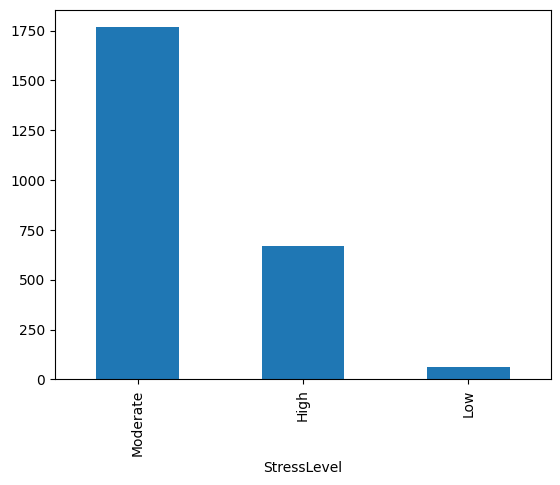

In [538]:
print(synthetic_stress['StressLevel'].value_counts())
synthetic_stress['StressLevel'].value_counts().plot(kind='bar')

The distribution of the target variable classes is not balanced, but when I will work on a real dataset, it might be the same. 

### Preprocessing

Dropping ID column as it is not needed for my case.

In [539]:
synthetic_stress.drop(['ID'], axis=1, inplace=True)
synthetic_stress.sample(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,clammy_hands,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel
486,D,C,A,C,A,C,C,C,B,C,...,B,C,B,B,D,B,B,B,C,Moderate
2236,B,B,A,A,D,A,A,C,A,D,...,A,B,C,B,B,B,B,B,D,Moderate
773,D,C,C,A,B,A,A,C,A,C,...,A,B,C,C,C,D,C,B,B,Moderate
2116,A,B,B,B,B,D,B,C,B,B,...,A,C,C,C,A,C,B,B,A,Moderate
2051,B,D,C,B,B,B,C,B,C,D,...,A,B,C,D,D,C,B,B,D,High


In [540]:
synthetic_features = ['achievement_satisfaction', 'irritation', 'hurry_to_finalize', 'self_doubt', 'rumination', 'emotional_repression', 'pessimism', 'disappointment_fretting', 'work_detachment', 'indecisiveness', 'easily_wound_up', 'loneliness', 'weather_mood', 'achievement_dissatisfaction', 'impatience', 'smoking', 'lack_confidence', 'unclear_thinking', 'rushed_work', 'poor_sleep', 'alcohol', 'relaxation_difficulty', 'poor_concentration', 'lack_exercise', 'noise_sensitivity', 'headaches', 'clammy_hands', 'criticism_sensitivity', 'panic_attacks', 'distrust', 'stomach_issues', 'people_pleasing', 'distractibility', 'easily_frightened', 'time_pressure']

Making values numerical. I figured as my data is categorical, I can just use sklearn OneHotEncoder, to save myself some time as it does the same thing, but I leave this for future improvement

In [541]:
synthetic_stress["achievement_satisfaction"] = synthetic_stress["achievement_satisfaction"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["irritation"] = synthetic_stress["irritation"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["hurry_to_finalize"] = synthetic_stress["hurry_to_finalize"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["self_doubt"] = synthetic_stress["self_doubt"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["rumination"] = synthetic_stress["rumination"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["emotional_repression"] = synthetic_stress["emotional_repression"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["pessimism"] = synthetic_stress["pessimism"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["disappointment_fretting"] = synthetic_stress["disappointment_fretting"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["work_detachment"] = synthetic_stress["work_detachment"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["indecisiveness"] = synthetic_stress["indecisiveness"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["easily_wound_up"] = synthetic_stress["easily_wound_up"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["loneliness"] = synthetic_stress["loneliness"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["weather_mood"] = synthetic_stress["weather_mood"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["achievement_dissatisfaction"] = synthetic_stress["achievement_dissatisfaction"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["impatience"] = synthetic_stress["impatience"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["smoking"] = synthetic_stress["smoking"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["lack_confidence"] = synthetic_stress["lack_confidence"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["unclear_thinking"] = synthetic_stress["unclear_thinking"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["rushed_work"] = synthetic_stress["rushed_work"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["poor_sleep"] = synthetic_stress["poor_sleep"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["alcohol"] = synthetic_stress["alcohol"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["relaxation_difficulty"] = synthetic_stress["relaxation_difficulty"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["poor_concentration"] = synthetic_stress["poor_concentration"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["lack_exercise"] = synthetic_stress["lack_exercise"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["noise_sensitivity"] = synthetic_stress["noise_sensitivity"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["headaches"] = synthetic_stress["headaches"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["clammy_hands"] = synthetic_stress["clammy_hands"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["criticism_sensitivity"] = synthetic_stress["criticism_sensitivity"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["panic_attacks"] = synthetic_stress["panic_attacks"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["distrust"] = synthetic_stress["distrust"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["stomach_issues"] = synthetic_stress["stomach_issues"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["people_pleasing"] = synthetic_stress["people_pleasing"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["distractibility"] = synthetic_stress["distractibility"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["easily_frightened"] = synthetic_stress["easily_frightened"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)
synthetic_stress["time_pressure"] = synthetic_stress["time_pressure"].map({'A':0, 'B':1, 'C':2, 'D':3}).astype(int)

synthetic_stress["StressLevel"] = synthetic_stress["StressLevel"].map({'Low':0, 'Moderate':1, 'High':2}).astype(int)

I have modified the heatmap a bit so it covers all features and is not a huge mess at the same time

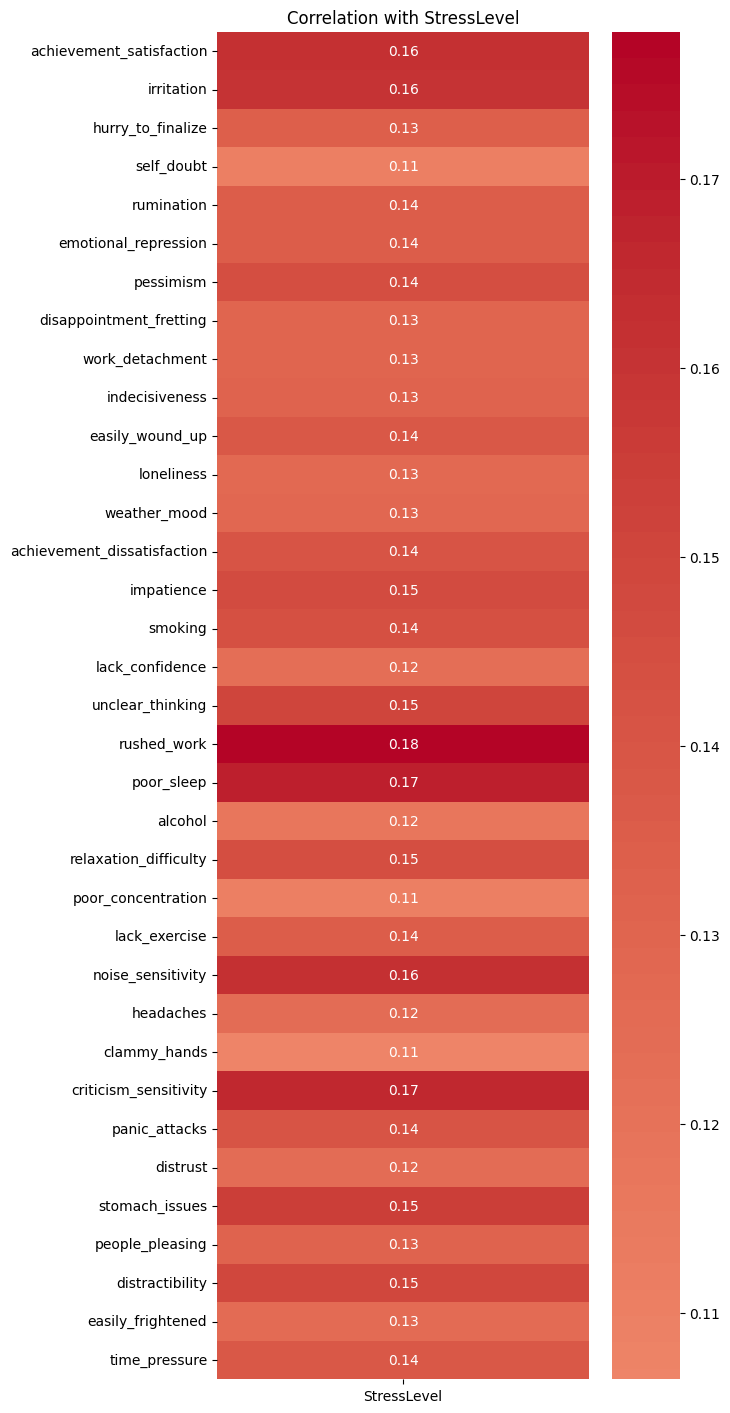

In [542]:
correlation_matrix = synthetic_stress.corr()
stress_corr = correlation_matrix[['StressLevel']].drop('StressLevel')
plt.figure(figsize=(6, len(stress_corr) * 0.5)) 
sns.heatmap(stress_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation with StressLevel')
plt.show()

The problem with such data is that the relation between categorical features and categorical target variable is that its hard to see using normal pairplot or heatmap, so I wil try to use approaches I have found on the internet for such case 

To save space I will perform the tests only on those features that have stronger correlation (heatmap)

First thing I will try is to use boxplot, to see which categories of a feature relate to specific categories 

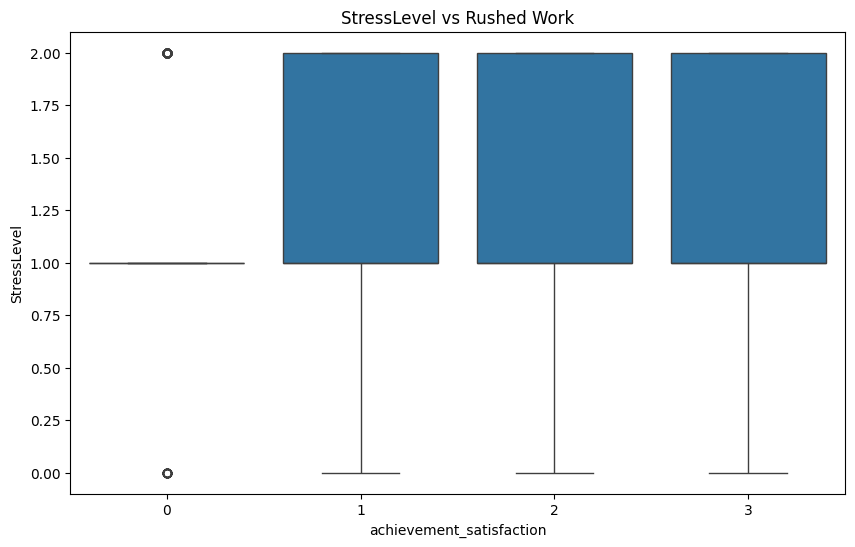

In [543]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=synthetic_stress, x='achievement_satisfaction', y='StressLevel')
plt.title('StressLevel vs Rushed Work')
plt.show()

From here it can be seen that the values of rushed work 2 and 3 (which is C(often), D(always)), have high density in categories 1 and 2 of the target variable (). Another thing I can pin point is the outliers in rushed_work 0 and 1 in category 2 of the StressLevel. I will cover this in the conclusion.

The second approach I have found is a crossatab. It shows pretty muc the same thing as the boxplot but in numeric view

In [544]:
contingency = pd.crosstab(synthetic_stress['achievement_satisfaction'], synthetic_stress['StressLevel'])
print(contingency)

StressLevel                0    1    2
achievement_satisfaction              
0                         28  461  102
1                         17  626  222
2                         15  448  196
3                          4  231  150


Third approach I have found is a chi-square test. This test is a technique to see if there is a significant relationship between two variables through category frequencies.

In [ ]:
import scipy.stats as stats
alpha = 0.05
chi_2, p_value, degrees_of_freedom, expected_values = stats.chi2_contingency(contingency)

print(f"Chi-square = {chi_2:.2f}")
print(f"p-value = {p_value:.14f}")
if p_value < alpha:
    print("The variables are dependent: There is a significant association.")
else:
    print("The variables are independent: There is no significant association.")

print("Expected frequencies:\n", expected_values)

Chi-square = 71.43
p-value = 0.00000000000021
Reject the null hypothesis: There is a significant association between irritation and stress level.
Expected frequencies:
 [[ 15.1296 417.4824 158.388 ]
 [ 22.144  611.036  231.82  ]
 [ 16.8704 465.5176 176.612 ]
 [  9.856  271.964  103.18  ]]


Before chi-square test people usually have 2 hypothesis about the data:
- H0 - The two variables are independent;
- H1 -  The variables are associated;

The calculations needed for the test are:
- Actual(observed) frequencies;
- Alpha value (the risk of drawing the wrong conclusion);
- Expected values - counts, expected if H0 hypothesis was true ((Row total)*(Column total)/Grand total);
- Chi-square statistic - deviation of observed values from expected values;
- Degrees of Freedom - how many values can vary dof=(number of rows−1)×(number of columns−1);
- P-value - area under the distribution curve to the right of the test statistic. If this value is smaller than the alpha value (0.05), the H0 is rejected and there is likely a relationship. If the value is bigger than alpha value, the observed result has probably happened by chance.

In this case, the p-value is smaller than the alpha, so the relation is likely present.

The chi-square test does not tell how strong the association is, just tells if there is any and the method can be considered useful.

There is one more indicator but I will come to it in the evaluation part

#### Feature Selection

I will keep all the features, as the last thing that is nice to see is the feature importances in the tree model 

In [546]:
X_synthetic_stress = synthetic_stress[['achievement_satisfaction', 'irritation', 'hurry_to_finalize', 'self_doubt', 'rumination', 'emotional_repression', 'pessimism', 'disappointment_fretting', 'work_detachment', 'indecisiveness', 'easily_wound_up', 'loneliness', 'weather_mood', 'achievement_dissatisfaction', 'impatience', 'smoking', 'lack_confidence', 'unclear_thinking', 'rushed_work', 'poor_sleep', 'alcohol', 'relaxation_difficulty', 'poor_concentration', 'lack_exercise', 'noise_sensitivity', 'headaches', 'clammy_hands', 'criticism_sensitivity', 'panic_attacks', 'distrust', 'stomach_issues', 'people_pleasing', 'distractibility', 'easily_frightened', 'time_pressure']]
y_synthetic_stress = synthetic_stress['StressLevel']

#### Train test split

In [547]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=5)
# skf.get_n_splits(X_synthetic_stress, y_synthetic_stress)
X_train, X_test, y_train, y_test = train_test_split(X_synthetic_stress, y_synthetic_stress, test_size=.2)
print("There are in total", len(X_synthetic_stress), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 2500 observations, of which 2000 are now in the train set, and 500 in the test set.


### Random Forest 

#### Modeling

I am using several models to see how different models would perform on the data. I am mostly using tree models, as in the future they will help me implement one idea of mine, but right now the data is not too good for this.

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.77

The models accuracy has reached 75% which is relatively good, and can identify that the ways of seeing relations may be working

#### Evaluation

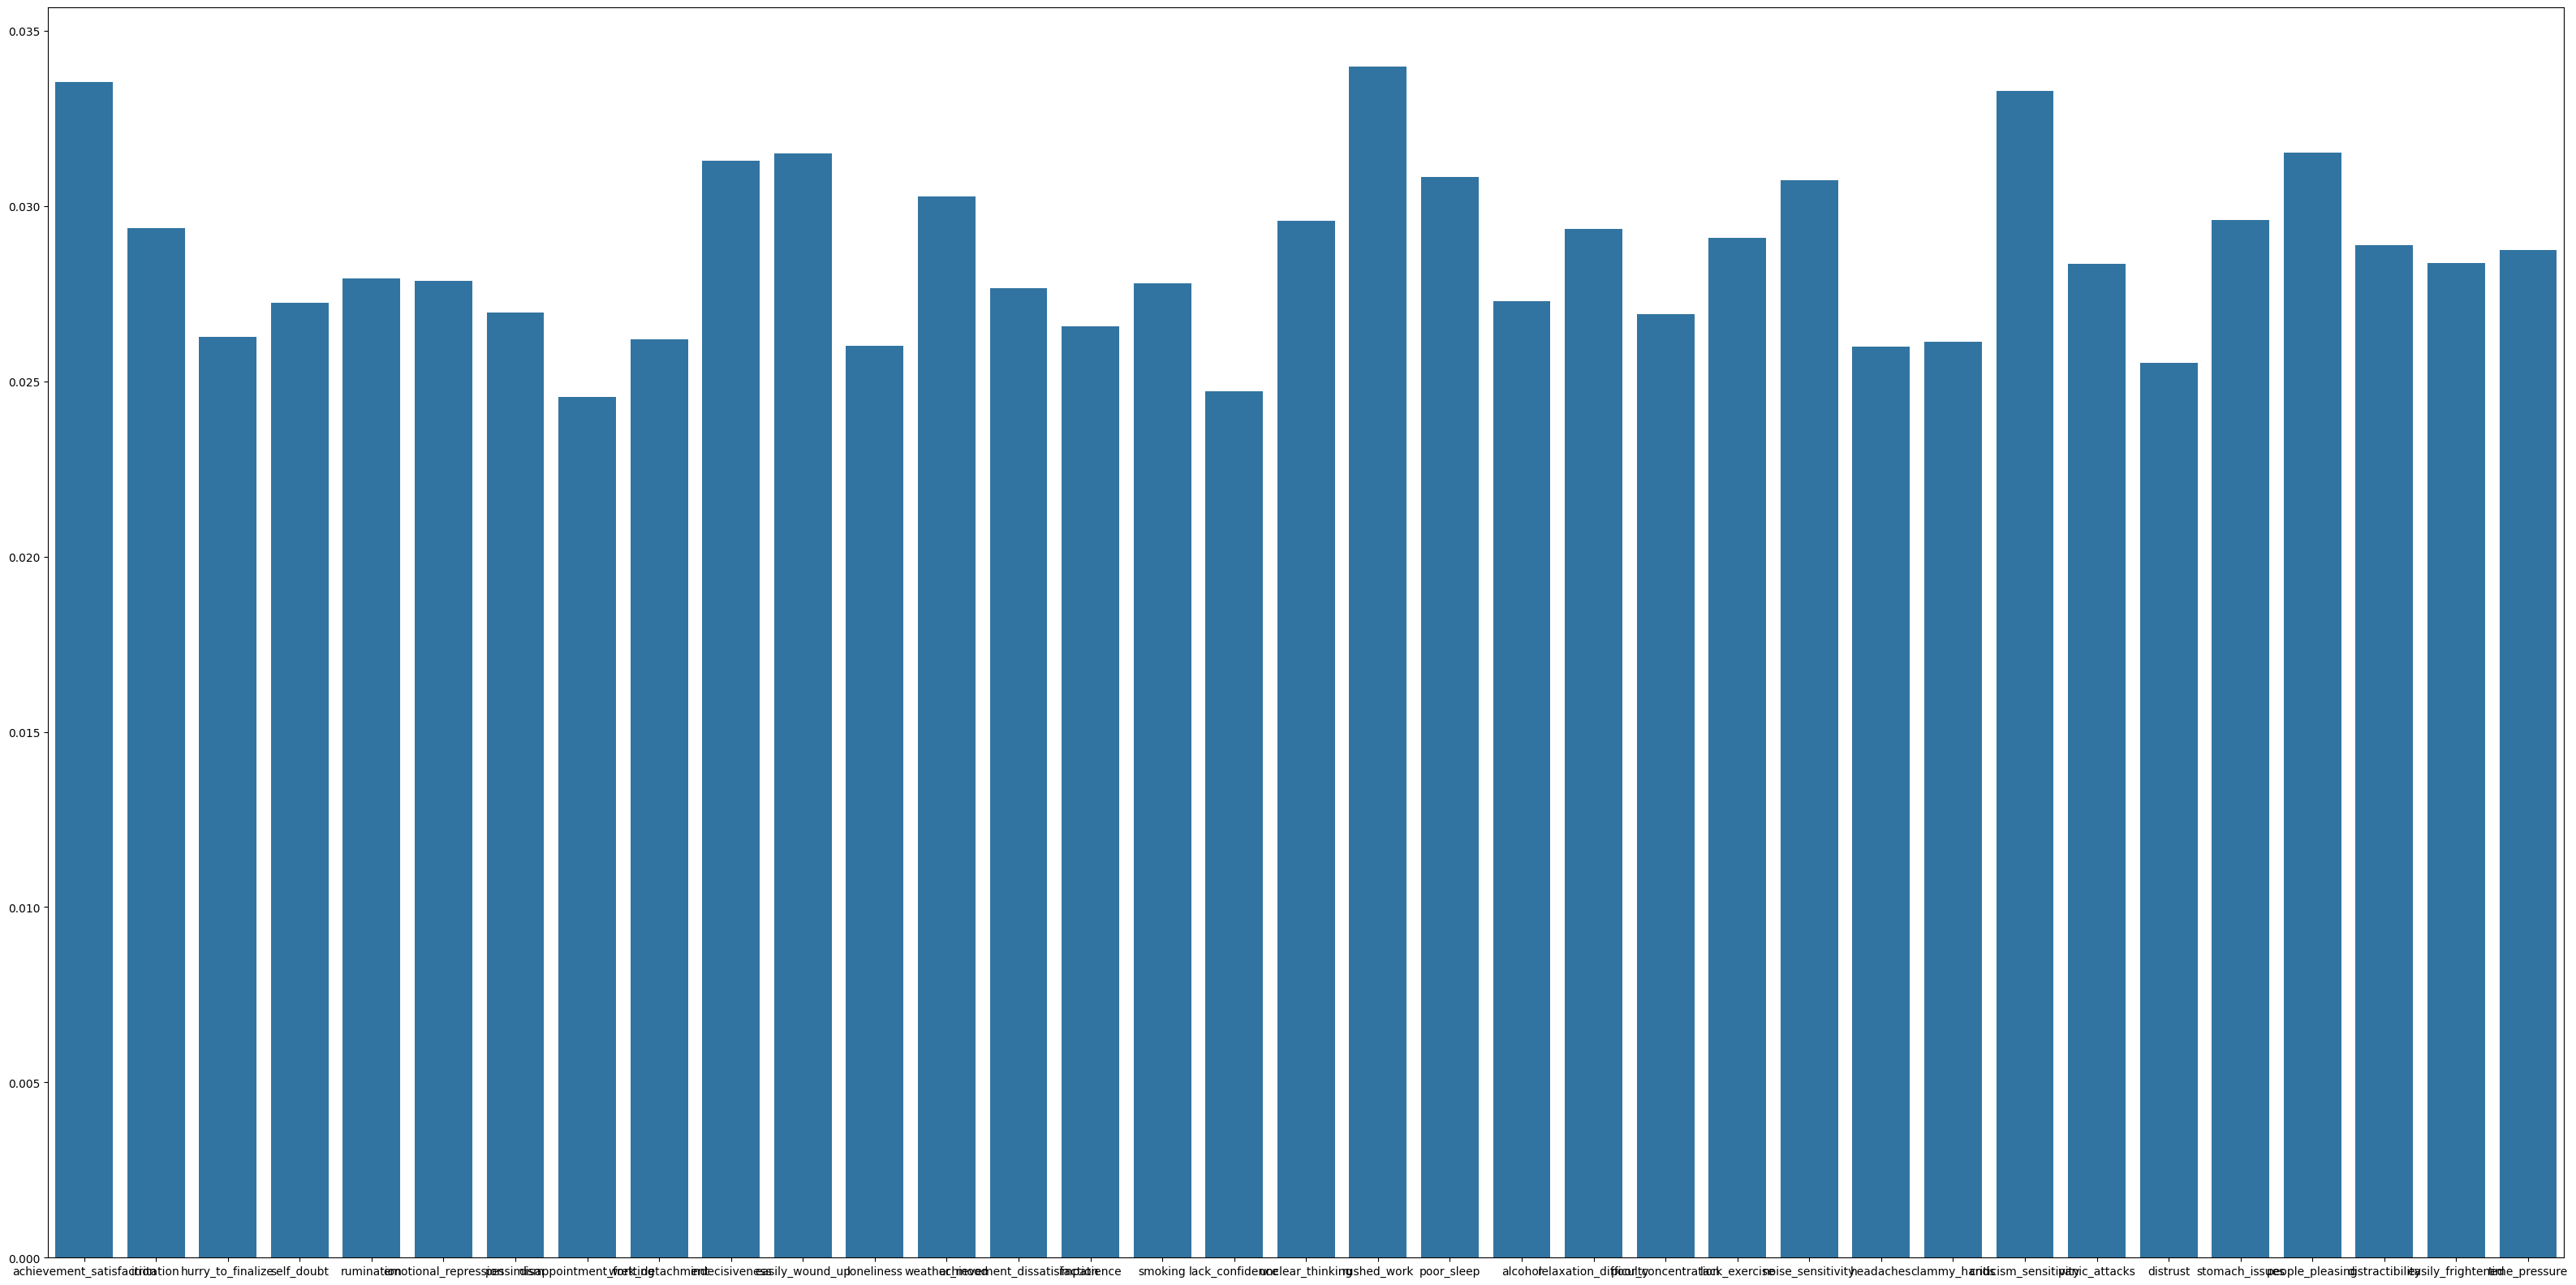

In [549]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=model.feature_importances_, x=synthetic_features)
plt.show()

As I have mentioned in the Preprocessing part, the last thing we can see when it comes to relation between the features and the target variable is the feature importance in a tree-like models. In the plot above it can be seen that each feature has played an important part in the decision, which is very good.

### Clustering

One thing that is nice to see is how does the clustering work in my project

#### Modeling 

From some experiments with the Agglomerative Clustering, one thing that I have to tune is the number of clusters, as without this parameter the model founds 370 clusters, which is completely off.

In [550]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(n_clusters=3, compute_distances=True)
agglom.fit(X_synthetic_stress)

print('Number of clusters: ',agglom.n_clusters_)

Number of clusters:  3


In [551]:
print(np.unique(agglom.labels_))

[0 1 2]


In [552]:
print(agglom.n_leaves_)

2500


#### Evaluation

I have taken the code for plotting the dendogram from the Clustering exercise. It shows how the clusters were made 

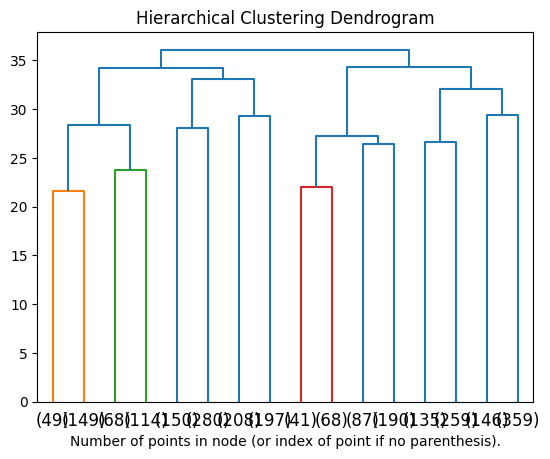

In [553]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(agglom, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [554]:
synthetic_stress['Cluster'] = agglom.labels_.astype(str)
synthetic_stress['Cluster'] = 'Cluster ' + synthetic_stress['Cluster']
synthetic_stress.head(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel,Cluster
0,1,2,0,2,0,2,0,2,0,0,...,3,1,2,3,3,2,2,2,2,Cluster 1
1,1,0,2,1,1,0,0,0,1,0,...,1,0,2,2,2,1,0,0,0,Cluster 0
2,1,1,0,1,2,3,2,1,2,2,...,2,2,3,0,3,3,3,2,2,Cluster 0
3,3,1,1,0,1,1,1,2,2,2,...,3,1,3,0,1,1,1,3,2,Cluster 1
4,2,1,3,1,2,1,2,1,2,2,...,2,2,0,2,3,0,3,1,2,Cluster 1


In [555]:
synthetic_stress.tail(5)

,achievement_satisfaction,irritation,hurry_to_finalize,self_doubt,rumination,emotional_repression,pessimism,disappointment_fretting,work_detachment,indecisiveness,...,criticism_sensitivity,panic_attacks,distrust,stomach_issues,people_pleasing,distractibility,easily_frightened,time_pressure,StressLevel,Cluster
2495,1,3,0,1,3,0,1,2,2,2,...,1,3,1,0,0,1,1,1,1,Cluster 1
2496,0,0,1,1,0,3,0,2,1,0,...,3,0,0,1,3,3,3,1,1,Cluster 1
2497,1,3,2,2,3,1,0,2,0,1,...,1,2,0,2,0,2,1,2,1,Cluster 0
2498,3,3,2,0,0,0,0,1,2,1,...,2,2,1,2,3,1,0,1,2,Cluster 0
2499,2,3,3,2,1,1,1,3,1,2,...,0,3,3,1,3,2,3,2,2,Cluster 0


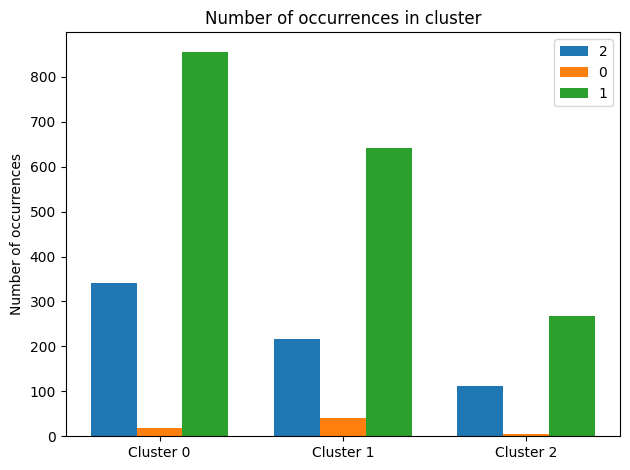

In [556]:
# Define labels for species
species = synthetic_stress['StressLevel'].unique()

# Define labels for clusters
clusters = synthetic_stress['Cluster'].unique()

# Sort cluster names in alphabetical order, i.e.,
# Cluster 0, Cluster 1, Cluster 2, etc.
clusters.sort()

# Determine the location for cluster labels 
x = np.arange(len(clusters))

# Define the width of the bars
width = 0.25

# Create the bar plot
fig, ax = plt.subplots()
offset = -width
for spec in species:
    nr_occurrences = []
    for clus in clusters:
        nr = synthetic_stress[(synthetic_stress['StressLevel']==spec) & (synthetic_stress['Cluster']==clus)]['Cluster'].count()
        nr_occurrences.append(nr)
    rects = ax.bar(x + offset, nr_occurrences, width, label=spec)
    offset = offset + width

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of occurrences')
ax.set_title('Number of occurrences in cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()

fig.tight_layout()
plt.show()

In [557]:
print(synthetic_stress['StressLevel'].value_counts())
print(synthetic_stress['Cluster'].value_counts())

levels = synthetic_stress['StressLevel'].unique()
for level in levels:
    print('Number of samples per cluster for',spec)
    print(synthetic_stress[synthetic_stress['StressLevel']==spec]['Cluster'].value_counts())

StressLevel
1    1766
2     670
0      64
Name: count, dtype: int64
Cluster
Cluster 0    1215
Cluster 1     899
Cluster 2     386
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64
Number of samples per cluster for 1
Cluster
Cluster 0    856
Cluster 1    642
Cluster 2    268
Name: count, dtype: int64


### Decision Tree Classifier

#### Modeling

In [558]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.742


#### Evaluation

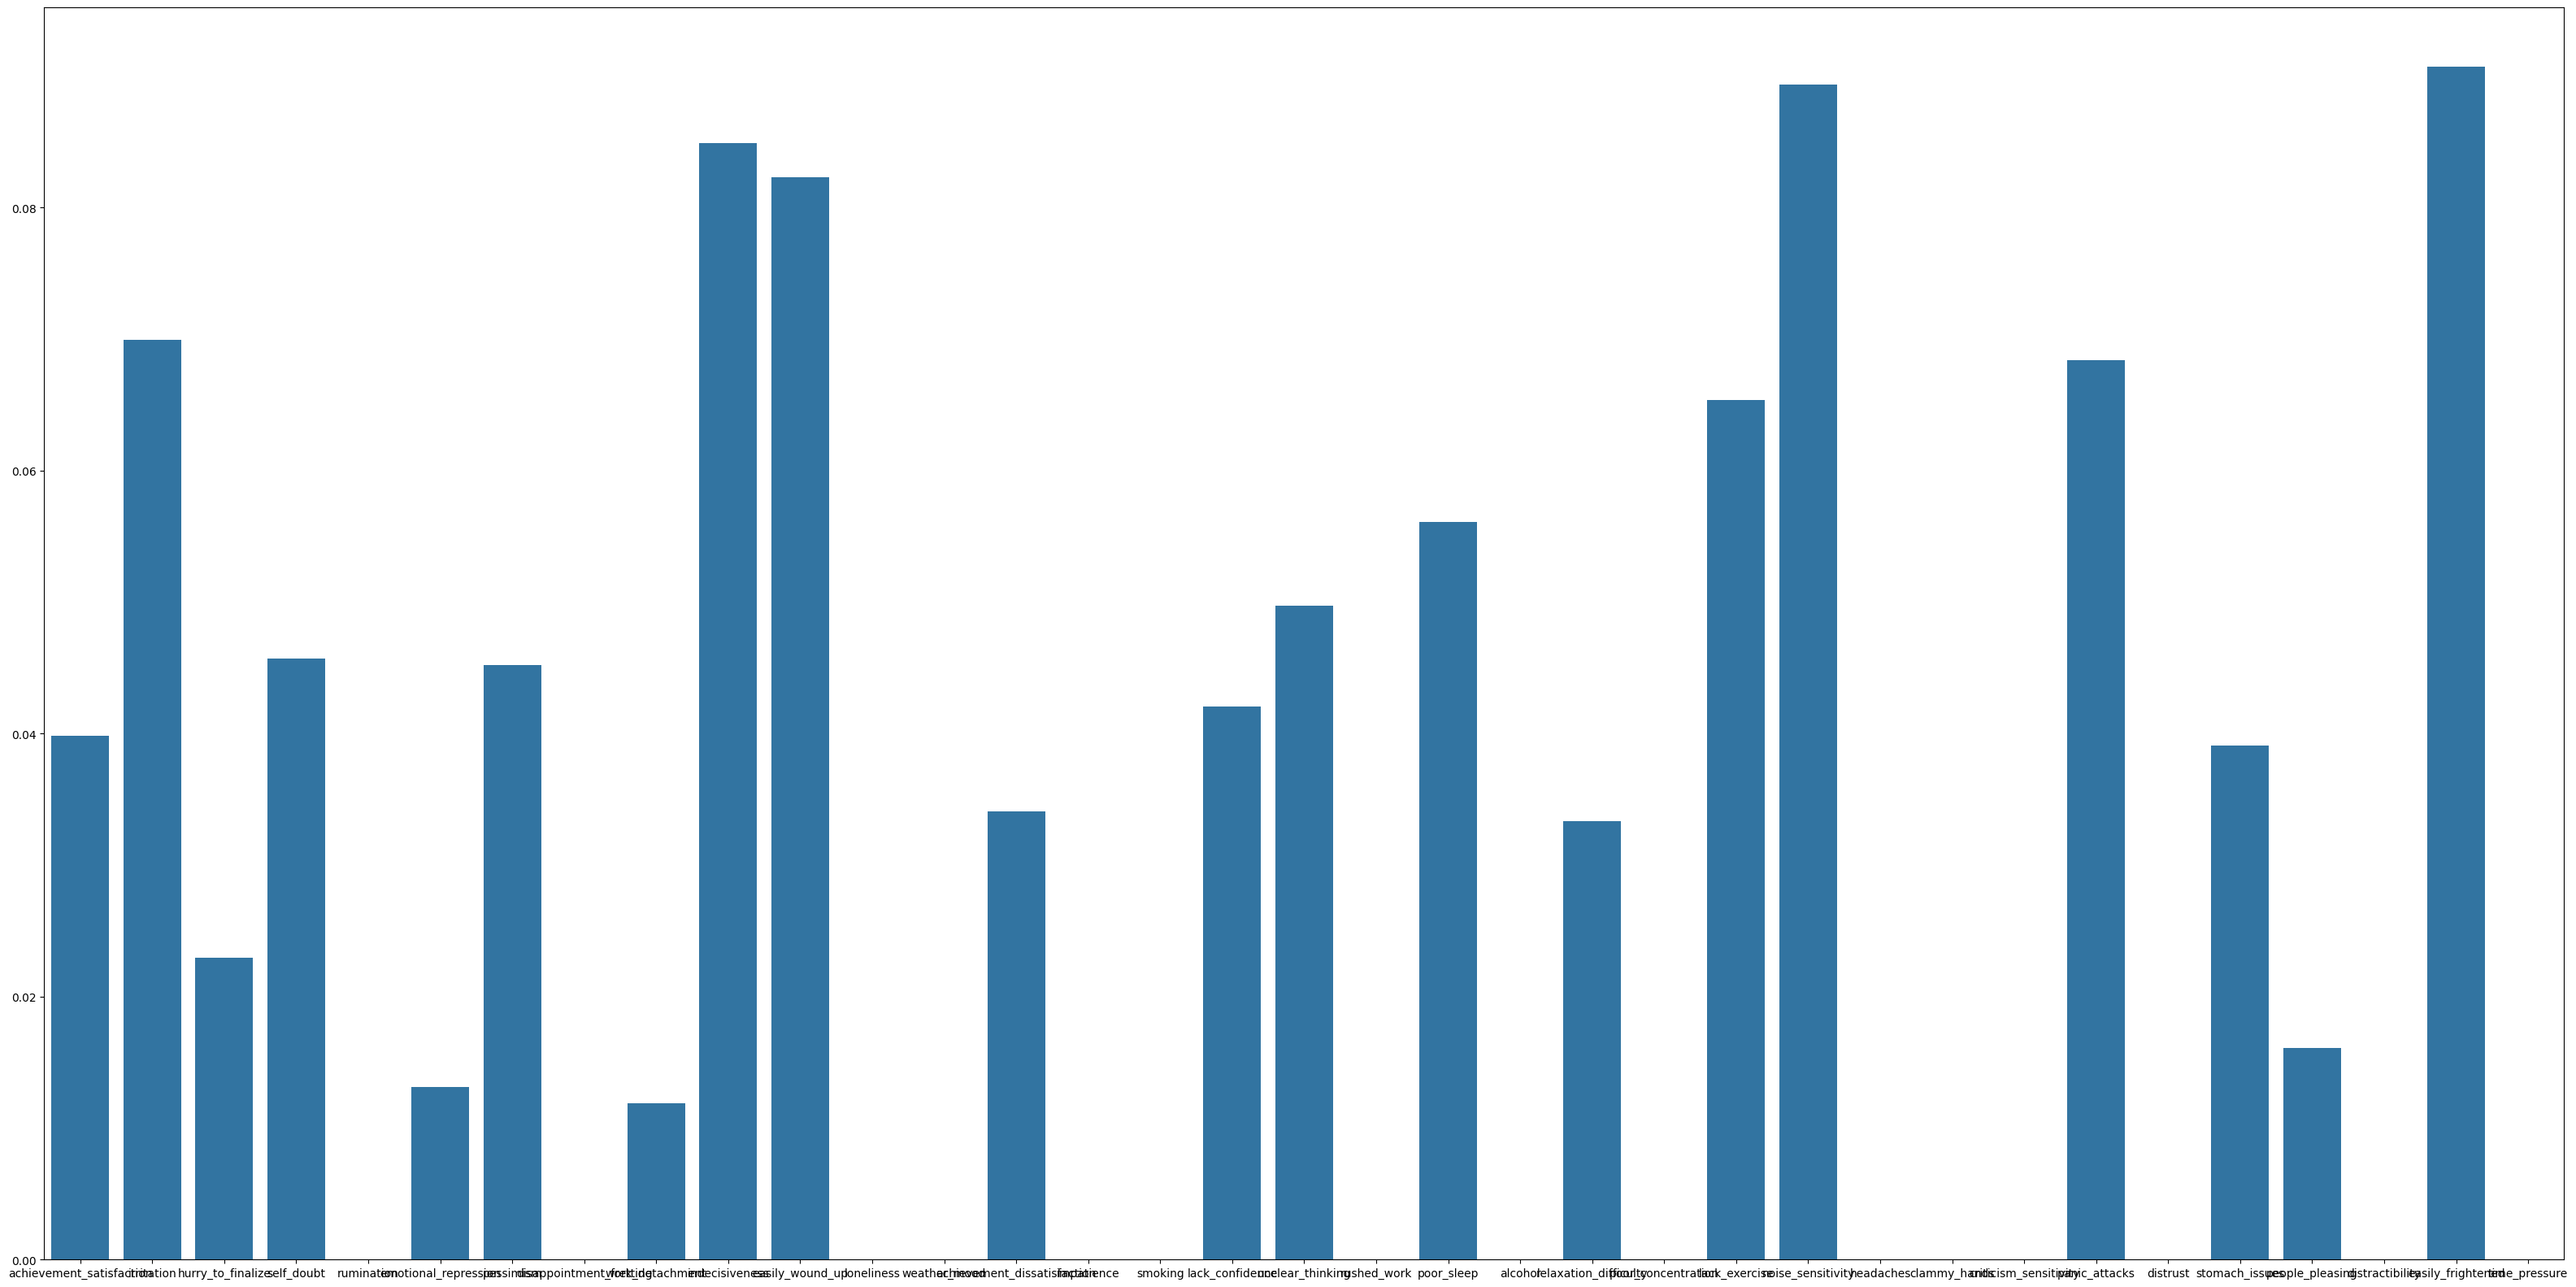

In [559]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=model.feature_importances_, x=synthetic_features)
plt.show()

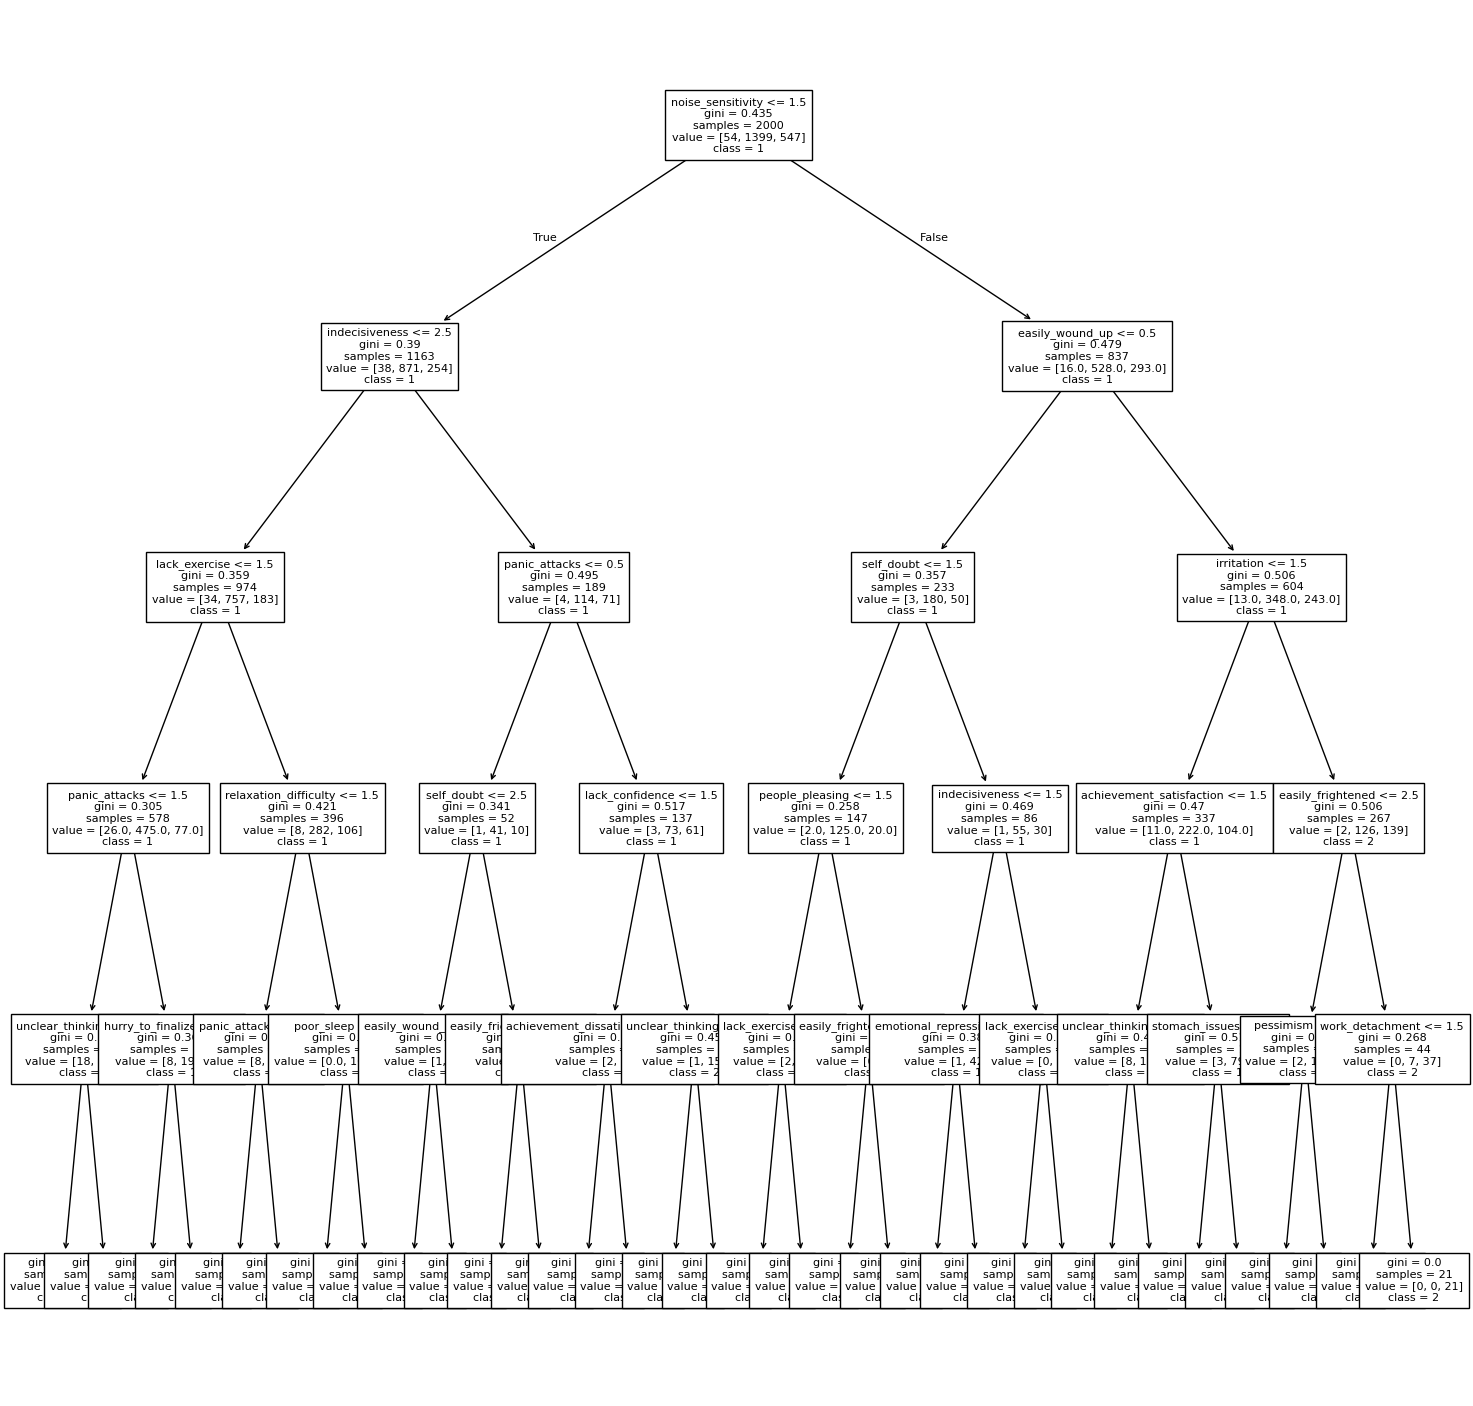

In [560]:
target_names = ["0", "1", "2"]
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
from sklearn.tree import plot_tree
plot_tree(model, fontsize=8, feature_names=synthetic_features, class_names=target_names)
plt.show()

In [561]:
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.77      0.93      0.84       367
           2       0.53      0.25      0.34       123

    accuracy                           0.74       500
   macro avg       0.43      0.39      0.39       500
weighted avg       0.70      0.74      0.70       500



c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Fontys Student Stress Survey

From my iteration 0 and Synthetic Dataset part I have made a google form and posted it to Fontys students: https://docs.google.com/forms/d/e/1FAIpQLSe1NUOqiga-TfrjSjefwqrSNO9Jr5bqO_mSAaaqc8q0OSme9g/viewform?usp=sharing

Briefly, I have taken general questions (study time, sleep time, part time job, etc.) and PSS (Perceived Stress Scale) from my Iteration 0, stress-resistance test questions and life events (was a table but transformed into individual questions, due to ethical concerns) from the book "Busy, busy, busy".

The form is connected to a google sheet, from where I will get the data in runtime

### Data Provisioning

In order to get the data from google sheets to python I have followed a video on youtube (https://www.youtube.com/watch?v=hyUw-koO2DA)

In [562]:
# define the scope and credentials
scopes = ['https://www.googleapis.com/auth/spreadsheets.readonly', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('google-sheets-access/student-stress-457900-e232b54e76fb.json', scopes=scopes)

# authorize and open the workbook
file = gspread.authorize(creds)
workbook = file.open('fontys_student_stress')
sheet = workbook.worksheet('stress')

# get all records from the sheet and convert to a pandas DataFrame
data = sheet.get_all_records()
df = pd.DataFrame(data)

print(df)

          Позначка часу  \
0   25.04.2025 03:11:16   
1   25.04.2025 03:41:40   
2   25.04.2025 06:20:56   
3   25.04.2025 08:12:13   
4   25.04.2025 09:13:27   
5   25.04.2025 09:15:32   
6   25.04.2025 09:34:21   
7   25.04.2025 10:20:11   
8   25.04.2025 10:33:02   
9   25.04.2025 10:40:57   
10  25.04.2025 11:16:51   
11  25.04.2025 11:23:50   
12  25.04.2025 11:35:10   
13  25.04.2025 19:59:30   
14  25.04.2025 19:59:56   
15  25.04.2025 20:00:57   
16  25.04.2025 20:04:28   
17  25.04.2025 21:02:08   
18  25.04.2025 21:12:23   
19  26.04.2025 02:24:50   
20  27.04.2025 12:33:56   
21  27.04.2025 16:16:53   
22  29.04.2025 00:34:20   
23  30.04.2025 22:45:22   
24  03.05.2025 21:10:25   
25  04.05.2025 00:42:53   
26  04.05.2025 00:56:17   
27  04.05.2025 01:12:45   
28  04.05.2025 08:43:23   
29  04.05.2025 08:51:23   
30  04.05.2025 11:42:22   
31  04.05.2025 13:23:20   
32  04.05.2025 13:58:56   
33  04.05.2025 14:08:33   
34  04.05.2025 15:17:02   
35  04.05.2025 16:04:42   
3

In [563]:
df.to_csv('survey/fontys-student-stress-survey.csv', index=False)
fontys_stress = pd.read_csv('survey/fontys-student-stress-survey.csv')
fontys_stress.head()

,Позначка часу,How much time do you spend on studying daily? (in hours),Would you like to pursue a career based on your profile/specialization?,Do you have a part time job?,How many hours do you usually sleep?,How would you describe your diet?,"How much time do you spend on physical activities daily (general exercises, any sport counts)?",How often have you felt upset due to something that happened in your academic affairs?,How often you felt as if you were unable to control important things in your academic affairs?,How often you felt nervous and stressed because of academic pressure?,...,I have stomachaches and/or intestinal problems,Have you moved your house in the past 6 month?,Have you had any changes in your lifestyle recently?,Have you had any financial problems lately?,Have you had any sexual problems lately?,Have any of your fellow people been sick (family member or relative) lately?,Have you experienced any injury or sickness lately?,Have you been separated from your family/partner?,"Have you experienced a death of a fellow person (close relative, partner, friend)?","Overall, how would you describe your stress level?"
0,25.04.2025 03:11:16,2.333333,100%,Yes,6.0,Average,2.0,Very often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,25.04.2025 03:41:40,6.000000,100%,Yes,5.0,Healthy,2.0,Sometimes,Sometimes,Very often,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress
2,25.04.2025 06:20:56,3.000000,100%,Yes,6.0,Average,1.0,Sometimes,Almost never,Sometimes,...,Sometimes,Yes,Yes,No,No,Yes,No,No,No,Moderate stress
3,25.04.2025 08:12:13,4.000000,100%,Yes,4.0,Unhealthy,0.0,Very often,Very often,Very often,...,Always,No,No,No,No,No,No,Yes,No,High stress
4,25.04.2025 09:13:27,3.000000,50%,No,7.0,Average,0.5,Fairly often,Fairly often,Very often,...,Sometimes,No,No,No,No,No,No,No,No,Moderate stress


This isn't a step of data provisioning but I will rename the columns now for better readability of the dataset

In [564]:
# i have a ukrainian google account, the google form interface is in ukrainian, so the timestamp column is named in ukranian, my bad(
fontys_stress.drop(['Позначка часу'], axis=1, inplace=True)

# renaming columns
fontys_stress.rename(columns={"How much time do you spend on studying daily? (in hours)" : "time_studying"}, inplace=True)
fontys_stress.rename(columns={"Would you like to pursue a career based on your profile/specialization?" : "career_pursue"}, inplace=True)
fontys_stress.rename(columns={"Do you have a part time job?" : "part_time_job"}, inplace=True)
fontys_stress.rename(columns={"How many hours do you usually sleep?" : "time_sleep"}, inplace=True)
fontys_stress.rename(columns={"How would you describe your diet?" : "diet"}, inplace=True)
fontys_stress.rename(columns={"How much time do you spend on physical activities daily (general exercises, any sport counts)?" : "time_physical_activities"}, inplace=True)
fontys_stress.rename(columns={"How often have you felt upset due to something that happened in your academic affairs?" : "upset_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if you were unable to control important things in your academic affairs?" : "unable_control_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt nervous and stressed because of academic pressure?" : "nervous_academic_pressure"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if you could not cope with all the mandatory academic activities? (assignments, project requirements, etc.)" : "unable_cope_academic_activities"}, inplace=True)
fontys_stress.rename(columns={"How often you felt confident about your ability to handle your academic / university problems?" : "confident_handle_academic_problems"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if things in your academic life is going on your way?" : "things_going_on_way"}, inplace=True)
fontys_stress.rename(columns={"How often are you able to control irritations in your academic / university affairs?" : "control_irritations_academic_affairs"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if your academic performance was on top?" : "academic_performance_top"}, inplace=True)
fontys_stress.rename(columns={"How often you got angered due to bad performance or low grades that is beyond your control?" : "angered_bad_performance"}, inplace=True)
fontys_stress.rename(columns={"How often you felt as if academic difficulties are piling up so high that you could not overcome them?" : "academic_difficulties_piling_up"}, inplace=True)
fontys_stress.rename(columns={"I am never completely satisfied with my achievements" : "never_satisfied_achievements"}, inplace=True)
fontys_stress.rename(columns={"I am quickly irritated by other people" : "quickly_irritated_people"}, inplace=True)
fontys_stress.rename(columns={"The future seems gloomy to me" : "future_gloomy"}, inplace=True)
fontys_stress.rename(columns={"I quickly become impatient" : "quickly_impatient"}, inplace=True)
fontys_stress.rename(columns={"I smoke too much" : "smoke_too_much"}, inplace=True)
fontys_stress.rename(columns={"I find it hard to think clearly when I am in a difficult situation" : "hard_think_clearly"}, inplace=True)
fontys_stress.rename(columns={"I often feel rushed in my work " : "often_rushed_work"}, inplace=True)
fontys_stress.rename(columns={"I am not sleeping well" : "not_sleeping_well"}, inplace=True)
fontys_stress.rename(columns={"I am sensitive to noise" : "sensitive_noise"}, inplace=True)
fontys_stress.rename(columns={"I find criticism difficult and I don't deal with it well" : "find_criticism_difficult"}, inplace=True)
fontys_stress.rename(columns={"I often have panic attacks " : "panic_attacks"}, inplace=True)
fontys_stress.rename(columns={"I have stomachaches and/or intestinal problems" : "stomachaches"}, inplace=True)
fontys_stress.rename(columns={"Have you moved your house in the past 6 month?" : "moved_house"}, inplace=True)
fontys_stress.rename(columns={"Have you had any changes in your lifestyle recently?" : "changes_lifestyle"}, inplace=True)
fontys_stress.rename(columns={"Have you had any financial problems lately?" : "financial_problems"}, inplace=True)
fontys_stress.rename(columns={"Have you had any sexual problems lately?" : "sexual_problems"}, inplace=True)
fontys_stress.rename(columns={"Have any of your fellow people been sick (family member or relative) lately?" : "fellow_people_sick"}, inplace=True)
fontys_stress.rename(columns={"Have you experienced any injury or sickness lately?" : "experienced_injury"}, inplace=True)
fontys_stress.rename(columns={"Have you been separated from your family/partner?" : "separated_family"}, inplace=True)
fontys_stress.rename(columns={"Have you experienced a death of a fellow person (close relative, partner, friend)?" : "experienced_death"}, inplace=True)
fontys_stress.rename(columns={"Overall, how would you describe your stress level?" : "stress_level"}, inplace=True)

fontys_stress.head(5)


,time_studying,career_pursue,part_time_job,time_sleep,diet,time_physical_activities,upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,...,stomachaches,moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death,stress_level
0,2.333333,100%,Yes,6.0,Average,2.0,Very often,Fairly often,Fairly often,Fairly often,...,Never,No,Yes,No,No,No,Yes,Yes,Yes,High stress
1,6.000000,100%,Yes,5.0,Healthy,2.0,Sometimes,Sometimes,Very often,Sometimes,...,Never,No,Yes,No,No,No,No,Yes,Yes,Moderate stress
2,3.000000,100%,Yes,6.0,Average,1.0,Sometimes,Almost never,Sometimes,Almost never,...,Sometimes,Yes,Yes,No,No,Yes,No,No,No,Moderate stress
3,4.000000,100%,Yes,4.0,Unhealthy,0.0,Very often,Very often,Very often,Very often,...,Always,No,No,No,No,No,No,Yes,No,High stress
4,3.000000,50%,No,7.0,Average,0.5,Fairly often,Fairly often,Very often,Fairly often,...,Sometimes,No,No,No,No,No,No,No,No,Moderate stress


In [565]:
fontys_stress.to_csv('survey/fontys-student-stress-survey.csv', index=False)

Checking the data types with info()

In [566]:
fontys_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   time_studying                         37 non-null     float64
 1   career_pursue                         37 non-null     object 
 2   part_time_job                         37 non-null     object 
 3   time_sleep                            37 non-null     float64
 4   diet                                  37 non-null     object 
 5   time_physical_activities              37 non-null     float64
 6   upset_academic_affairs                37 non-null     object 
 7   unable_control_academic_affairs       37 non-null     object 
 8   nervous_academic_pressure             37 non-null     object 
 9   unable_cope_academic_activities       37 non-null     object 
 10  confident_handle_academic_problems    37 non-null     object 
 11  things_going_on_way  

Checking overall information about the collected dataset with describe()

In [567]:
fontys_stress.describe()

,time_studying,time_sleep,time_physical_activities
count,37.000000,37.000000,37.000000
mean,4.630631,6.709459,1.532432
std,2.455510,1.132710,1.778741
min,1.000000,4.000000,0.000000
25%,3.000000,6.000000,1.000000
50%,4.000000,7.000000,1.000000
75%,6.000000,7.750000,2.000000
max,10.000000,8.500000,10.000000


Although I have shared the survey not only to AI profile, but to all I could possibly reach (friends, students I know from previous semester, teachers), there are only 23 records (at the time I am doing the provisioning part, it can increase in the future)

Check the distribution of the target variable - stress_level

stress_level
Moderate stress    20
High stress        10
Low stress          7
Name: count, dtype: int64


<Axes: xlabel='stress_level'>

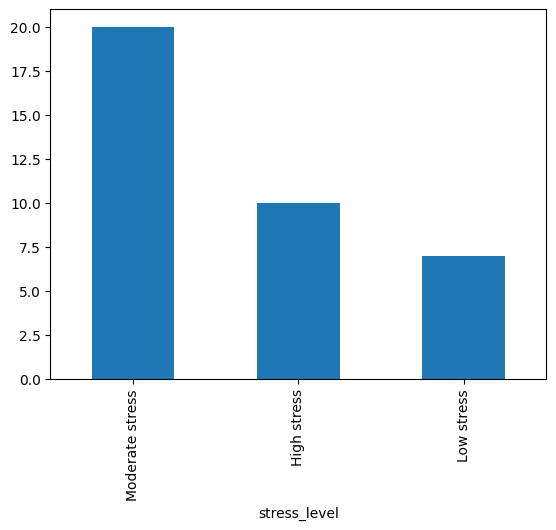

In [568]:
print(fontys_stress['stress_level'].value_counts())
fontys_stress['stress_level'].value_counts().plot(kind='bar')

The dataset is not balanced, but I have expected such results.

First part of the dataset I want to analyze is general questions, as it contains useful numeric data

Text(0, 0.5, 'Time Studying')

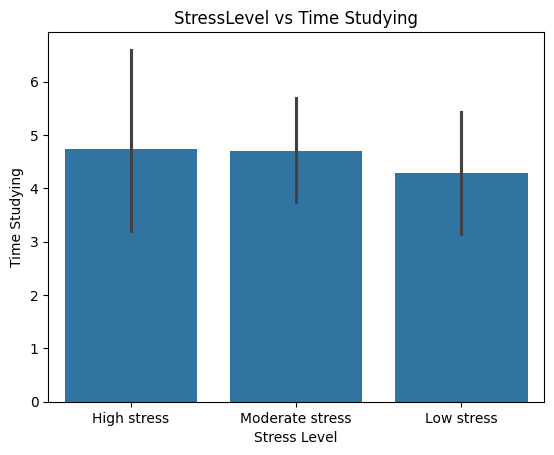

In [569]:
x = fontys_stress['stress_level']
y = fontys_stress['time_studying']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Time Studying')
plt.xlabel('Stress Level')
plt.ylabel('Time Studying')

The more time students spend on studying (daily) the lower the stress level is

Text(0, 0.5, 'Time Sleeping')

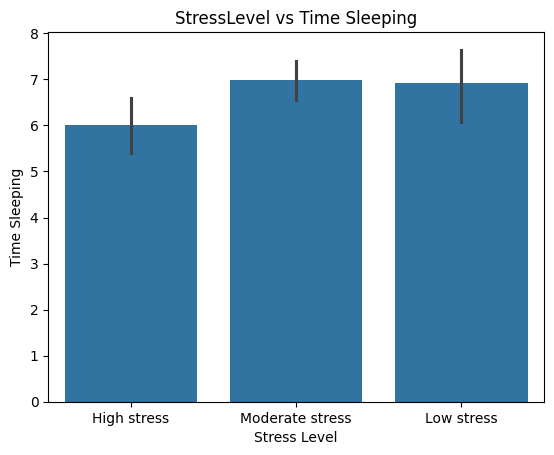

In [570]:
x = fontys_stress['stress_level']
y = fontys_stress['time_sleep']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Time Sleeping')
plt.xlabel('Stress Level')
plt.ylabel('Time Sleeping')

The difference in sleeping time and the stress levels is not big, but it can be seen that usually students with high stress sleep less.

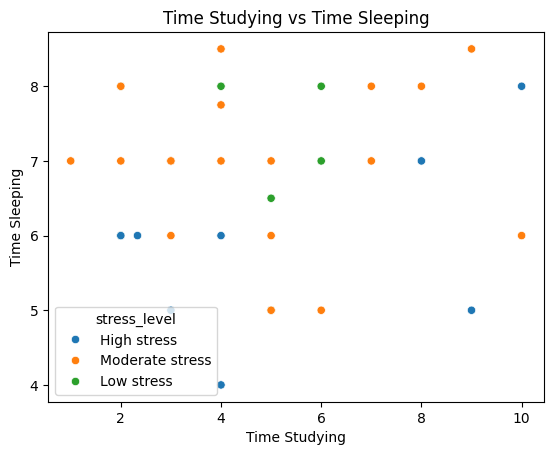

In [571]:
x = fontys_stress['time_studying']
y = fontys_stress['time_sleep']
plot = sns.scatterplot(x=x, y=y, hue=fontys_stress['stress_level'])
plt.title('Time Studying vs Time Sleeping')
plt.xlabel('Time Studying')
plt.ylabel('Time Sleeping')
plt.show()

I have tried to see the relation between studying and sleeping time, like "maybe the higher the sleeping and studying time is the lower is the stress level", but this doesn't show me much information. This is either because there is no relationship or it just can not be seen in the current state of my data.

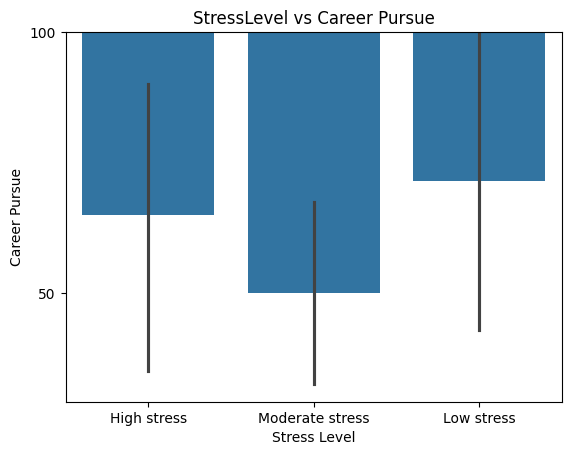

In [572]:
fontys_stress["career_pursue"] = fontys_stress["career_pursue"].str.replace("%","")
x = fontys_stress['stress_level']
y = fontys_stress['career_pursue']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Career Pursue')
plt.xlabel('Stress Level')
plt.ylabel('Career Pursue')
plt.show()

From the plot it can be seen the lines that come from the middle to the bottom of the plot. This indicates that there are no records of students who are willing to pursue their career in the chosen field of the university on 25% and 0%. It can also be seen that students with high and low stress usually want to work in the field they are studying more (75% and 100%). I assume that the results are the same for both levels as students with higher stress are those who feel behind in their studies and want to accomplish more, and students with low stress are those who are on track, have more knowledge (probably), and are just concentrated on studying

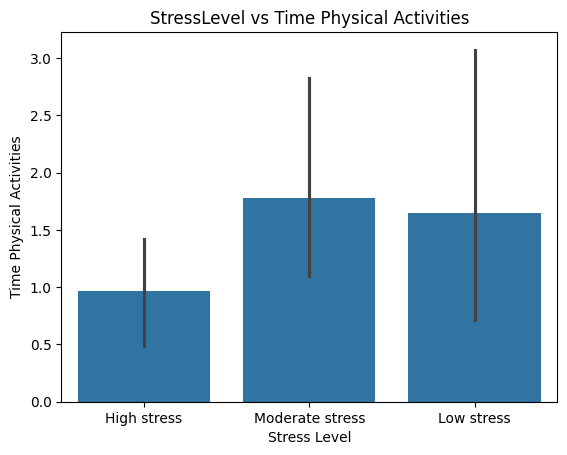

In [573]:
x = fontys_stress['stress_level']
y = fontys_stress['time_physical_activities']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Time Physical Activities')
plt.xlabel('Stress Level')
plt.ylabel('Time Physical Activities')
plt.show()

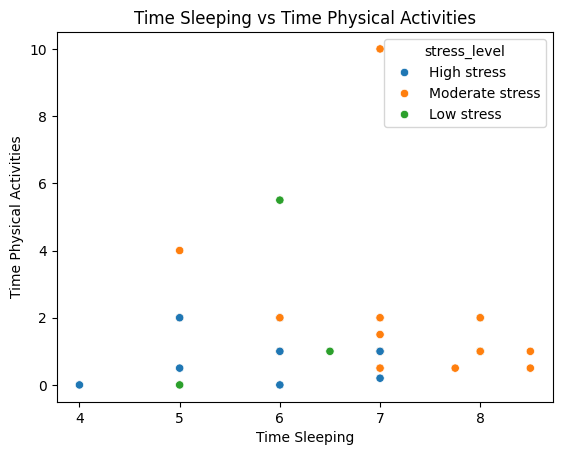

In [574]:
x = fontys_stress['time_sleep']
y = fontys_stress['time_physical_activities']
plot = sns.scatterplot(x=x, y=y, hue=fontys_stress['stress_level'])
plt.title('Time Sleeping vs Time Physical Activities')
plt.xlabel('Time Sleeping')
plt.ylabel('Time Physical Activities')
plt.show()

The number of records is probably not sufficient to see a pattern, but it can be seen that usually students who sleep and train more, often experience moderate stress.

As the other data is categorical, I will use different approaches to analyze it. 

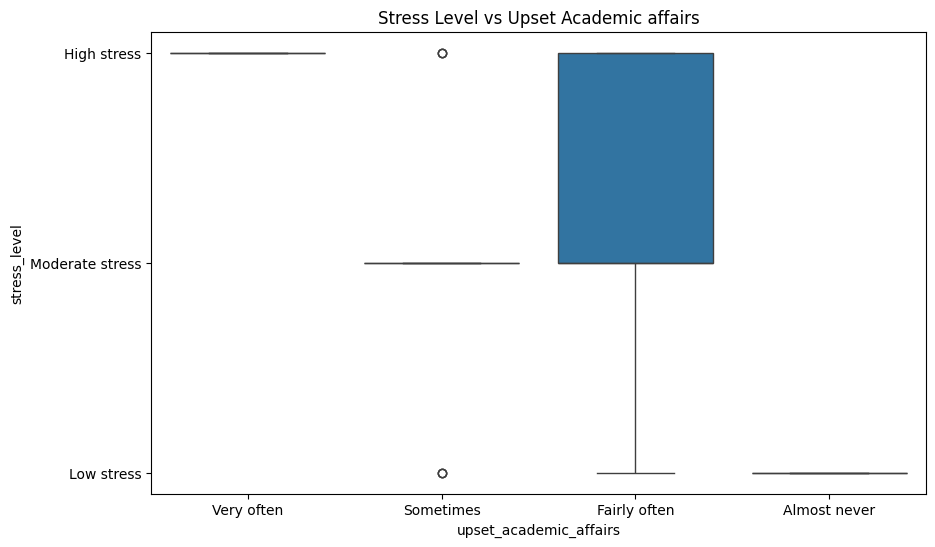

In [575]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=fontys_stress, x='upset_academic_affairs', y='stress_level')
plt.title('Stress Level vs Upset Academic affairs')
plt.show()

What I have found out is that barplots not always make sense before the preprocessing process, so the idea behind the boxplot is to see the density of answers to certain parameters. It can be seen that the relation between the categorical feature "upset_academic_affairs" and stress level is almost linear, as the medians of answers almost correlate to the target variable (Almost never - Low Stress; Very often - High stress)

In [576]:
contingency = pd.crosstab(fontys_stress['unable_control_academic_affairs'], fontys_stress['stress_level'])
print(contingency)

stress_level                     High stress  Low stress  Moderate stress
unable_control_academic_affairs                                          
Almost never                               1           3                6
Fairly often                               3           1                4
Never                                      1           0                0
Sometimes                                  4           3               10
Very often                                 1           0                0


Cross tab gives almost the same information as the boxplot but in numbers. It can be seen that for "unable_control_academic_affairs", the correlation is not as linear as in the example above

The last thing that is good to do is the chi-square test

### Preprocessing

The following part of code is used to see the unique answers of each set of questions

In [577]:
unique_pss = fontys_stress['upset_academic_affairs'].unique()
print(unique_pss)

unique_stress_resistance = fontys_stress['never_satisfied_achievements'].unique()
print(unique_stress_resistance)

unique_life_events = fontys_stress['moved_house'].unique()
print(unique_stress_resistance)

['Very often' 'Sometimes' 'Fairly often' 'Almost never']
['Always' 'Never' 'Often' 'Sometimes']
['Always' 'Never' 'Often' 'Sometimes']


Turning values into integers

In [578]:
fontys_features = ["time_studying", "career_pursue", "part_time_job", "time_sleep", "diet", "time_physical_activities", "upset_academic_affairs", "unable_control_academic_affairs", "nervous_academic_pressure", "unable_cope_academic_activities", "confident_handle_academic_problems", "things_going_on_way", "control_irritations_academic_affairs", "academic_performance_top", "angered_bad_performance", "academic_difficulties_piling_up", "never_satisfied_achievements", "quickly_irritated_people", "future_gloomy", "quickly_impatient", "smoke_too_much", "hard_think_clearly", "often_rushed_work", "not_sleeping_well", "sensitive_noise", "find_criticism_difficult", "panic_attacks", "stomachaches", "moved_house", "changes_lifestyle", "financial_problems", "sexual_problems", "fellow_people_sick", "experienced_injury", "separated_family", "experienced_death"]
general_questions = ["time_studying", "career_pursue", "part_time_job", "time-sleep", "diet", "time-physical-activities"]
pss = ["upset_academic_affairs", "unable_control_academic_affairs", "nervous_academic_pressure", "unable_cope_academic_activities", "confident_handle_academic_problems", "things_going_on_way", "control_irritations_academic_affairs", "academic_performance_top", "angered_bad_performance", "academic_difficulties_piling_up"]
stress_resistance = ["never_satisfied_achievements", "quickly_irritated_people", "future_gloomy", "quickly_impatient", "smoke_too_much", "hard_think_clearly", "I often feel rushed in my work", "not_sleeping_well", "sensitive_noise", "find_criticism_difficult", "I often have panic attacks"]
life_events = ["stomachaches", "moved_house", "changes_lifestyle", "financial_problems", "sexual_problems", "fellow_people_sick", "experienced_injury", "separated_family", "experienced_death"]
target = ["stress_level"]

# general_questions preprocessing
fontys_stress["career_pursue"] = fontys_stress["career_pursue"].str.replace("%","")
fontys_stress["part_time_job"] = fontys_stress["part_time_job"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["diet"] = fontys_stress["diet"].map({'Unhealthy': 0, 'Average': 1, 'Healthy': 2}).astype(int)

# pss (percieved stress scale) preprocessing
fontys_stress["upset_academic_affairs"] = fontys_stress["upset_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["unable_control_academic_affairs"] = fontys_stress["unable_control_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["nervous_academic_pressure"] = fontys_stress["nervous_academic_pressure"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["unable_cope_academic_activities"] = fontys_stress["unable_cope_academic_activities"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["confident_handle_academic_problems"] = fontys_stress["confident_handle_academic_problems"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["things_going_on_way"] = fontys_stress["things_going_on_way"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["control_irritations_academic_affairs"] = fontys_stress["control_irritations_academic_affairs"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["academic_performance_top"] = fontys_stress["academic_performance_top"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["angered_bad_performance"] = fontys_stress["angered_bad_performance"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)
fontys_stress["academic_difficulties_piling_up"] = fontys_stress["academic_difficulties_piling_up"].map({'Never': 0, 'Almost never': 1, 'Sometimes': 2, 'Fairly often': 3, 'Very often': 4}).astype(int)

# stress_resistance preprocessing
fontys_stress["never_satisfied_achievements"] = fontys_stress["never_satisfied_achievements"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["quickly_irritated_people"] = fontys_stress["quickly_irritated_people"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["future_gloomy"] = fontys_stress["future_gloomy"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["quickly_impatient"] = fontys_stress["quickly_impatient"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["smoke_too_much"] = fontys_stress["smoke_too_much"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["hard_think_clearly"] = fontys_stress["hard_think_clearly"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["often_rushed_work"] = fontys_stress["often_rushed_work"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["not_sleeping_well"] = fontys_stress["not_sleeping_well"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["sensitive_noise"] = fontys_stress["sensitive_noise"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["find_criticism_difficult"] = fontys_stress["find_criticism_difficult"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["panic_attacks"] = fontys_stress["panic_attacks"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)
fontys_stress["stomachaches"] = fontys_stress["stomachaches"].map({'Never': 0, 'Sometimes': 1, 'Often': 2, 'Always': 3}).astype(int)

# life_events preprocessing
fontys_stress["moved_house"] = fontys_stress["moved_house"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["changes_lifestyle"] = fontys_stress["changes_lifestyle"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["financial_problems"] = fontys_stress["financial_problems"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["sexual_problems"] = fontys_stress["sexual_problems"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["fellow_people_sick"] = fontys_stress["fellow_people_sick"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["experienced_injury"] = fontys_stress["experienced_injury"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["separated_family"] = fontys_stress["separated_family"].map({'No': 0, 'Yes': 1}).astype(int)
fontys_stress["experienced_death"] = fontys_stress["experienced_death"].map({'No': 0, 'Yes': 1}).astype(int)

fontys_stress["stress_level"] = fontys_stress["stress_level"].map({'Low stress': 0, 'Moderate stress': 1, 'High stress': 2}).astype(int)

fontys_stress.sample(5)

,time_studying,career_pursue,part_time_job,time_sleep,diet,time_physical_activities,upset_academic_affairs,unable_control_academic_affairs,nervous_academic_pressure,unable_cope_academic_activities,...,stomachaches,moved_house,changes_lifestyle,financial_problems,sexual_problems,fellow_people_sick,experienced_injury,separated_family,experienced_death,stress_level
0,2.333333,100,1,6.0,1,2.0,4,3,3,3,...,0,0,1,0,0,0,1,1,1,2
27,2.000000,100,1,6.0,1,5.5,1,1,1,1,...,1,0,0,1,0,1,1,1,1,0
5,6.000000,100,1,7.0,1,1.0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
10,4.000000,50,1,8.5,1,0.5,2,1,2,2,...,0,0,0,0,0,1,0,0,1,1
14,3.000000,100,1,5.0,0,0.5,3,3,3,3,...,2,0,0,1,0,0,1,0,0,2


Now the bar plots of the categorical features give us useful information

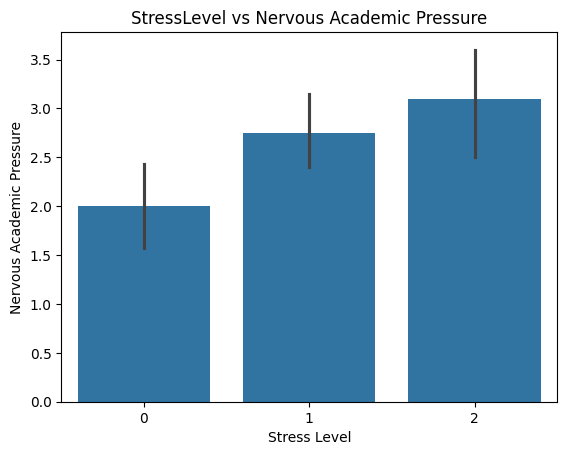

In [579]:
x = fontys_stress['stress_level']
y = fontys_stress['nervous_academic_pressure']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Nervous Academic Pressure')
plt.xlabel('Stress Level')
plt.ylabel('Nervous Academic Pressure')
plt.show()

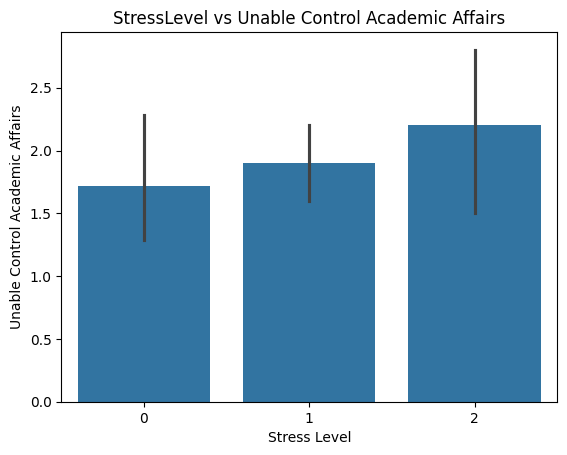

In [580]:
x = fontys_stress['stress_level']
y = fontys_stress['unable_control_academic_affairs']
plot = sns.barplot(x=x, y=y)
plt.title('StressLevel vs Unable Control Academic Affairs')
plt.xlabel('Stress Level')
plt.ylabel('Unable Control Academic Affairs')
plt.show()

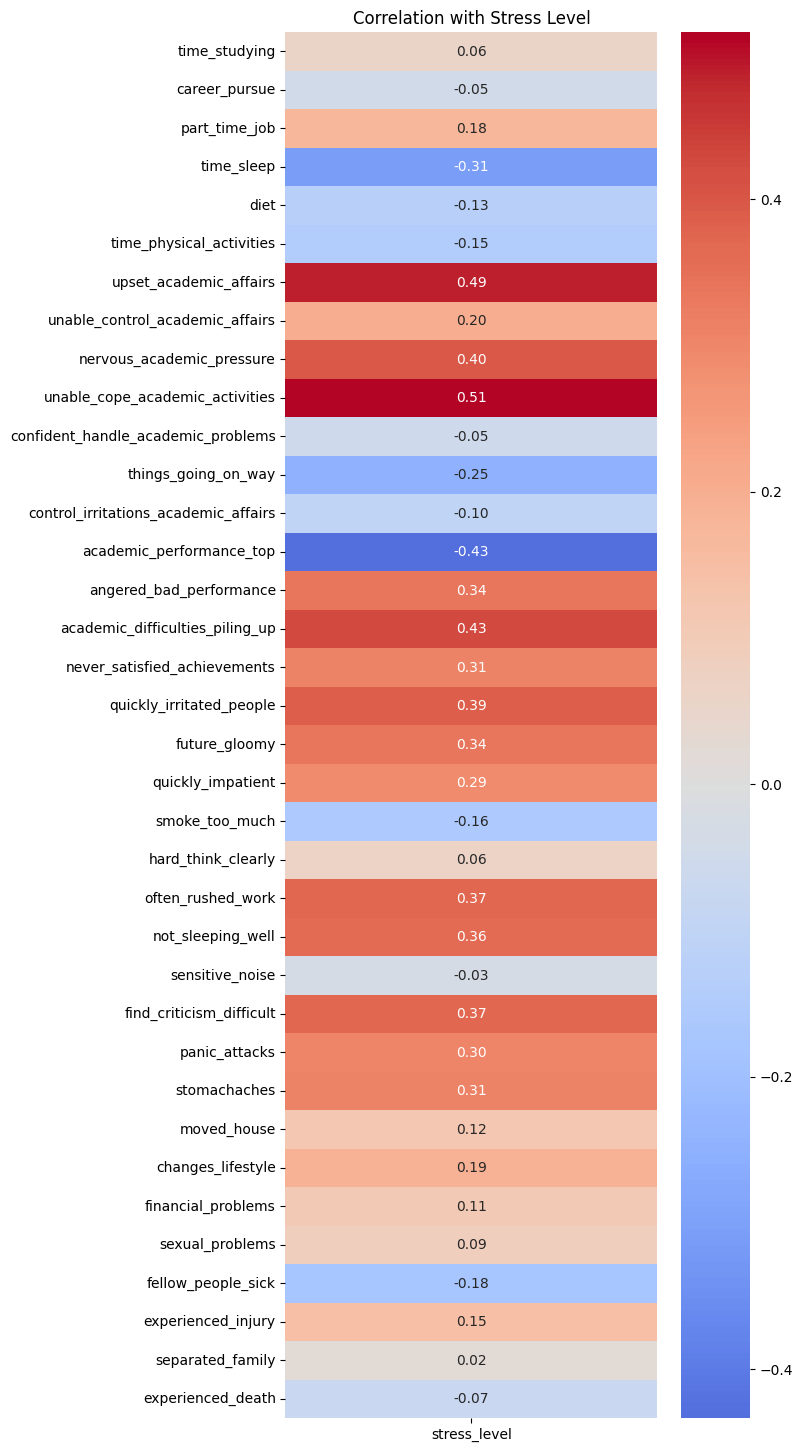

In [581]:
correlation_matrix = fontys_stress.corr()
stress_corr = correlation_matrix[['stress_level']].drop('stress_level')
plt.figure(figsize=(6, len(stress_corr) * 0.5)) 
sns.heatmap(stress_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation with Stress Level')
plt.show()

Concluding the results of th heat map plot, the correlations of features to target variable are as expected from the provisioning part

#### Feature Selection

I will use only features that have correlation more than 0.25 (or -0.25) for the modelling part

In [582]:
X_fontys_stress = fontys_stress[['part_time_job','time_sleep','diet','upset_academic_affairs','unable_control_academic_affairs','nervous_academic_pressure','unable_cope_academic_activities','things_going_on_way','academic_performance_top','angered_bad_performance','academic_difficulties_piling_up','never_satisfied_achievements','quickly_irritated_people','future_gloomy','quickly_impatient','smoke_too_much','often_rushed_work','not_sleeping_well','find_criticism_difficult','panic_attacks','stomachaches','financial_problems','experienced_injury']]
y_fontys_stress = fontys_stress['stress_level']

In [583]:
X_train, X_test, y_train, y_test = train_test_split(X_fontys_stress, y_fontys_stress, test_size=.2)
print("There are in total", len(X_fontys_stress), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 37 observations, of which 29 are now in the train set, and 8 in the test set.


### Modelling

#### Random forest

In [584]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test)

0.5

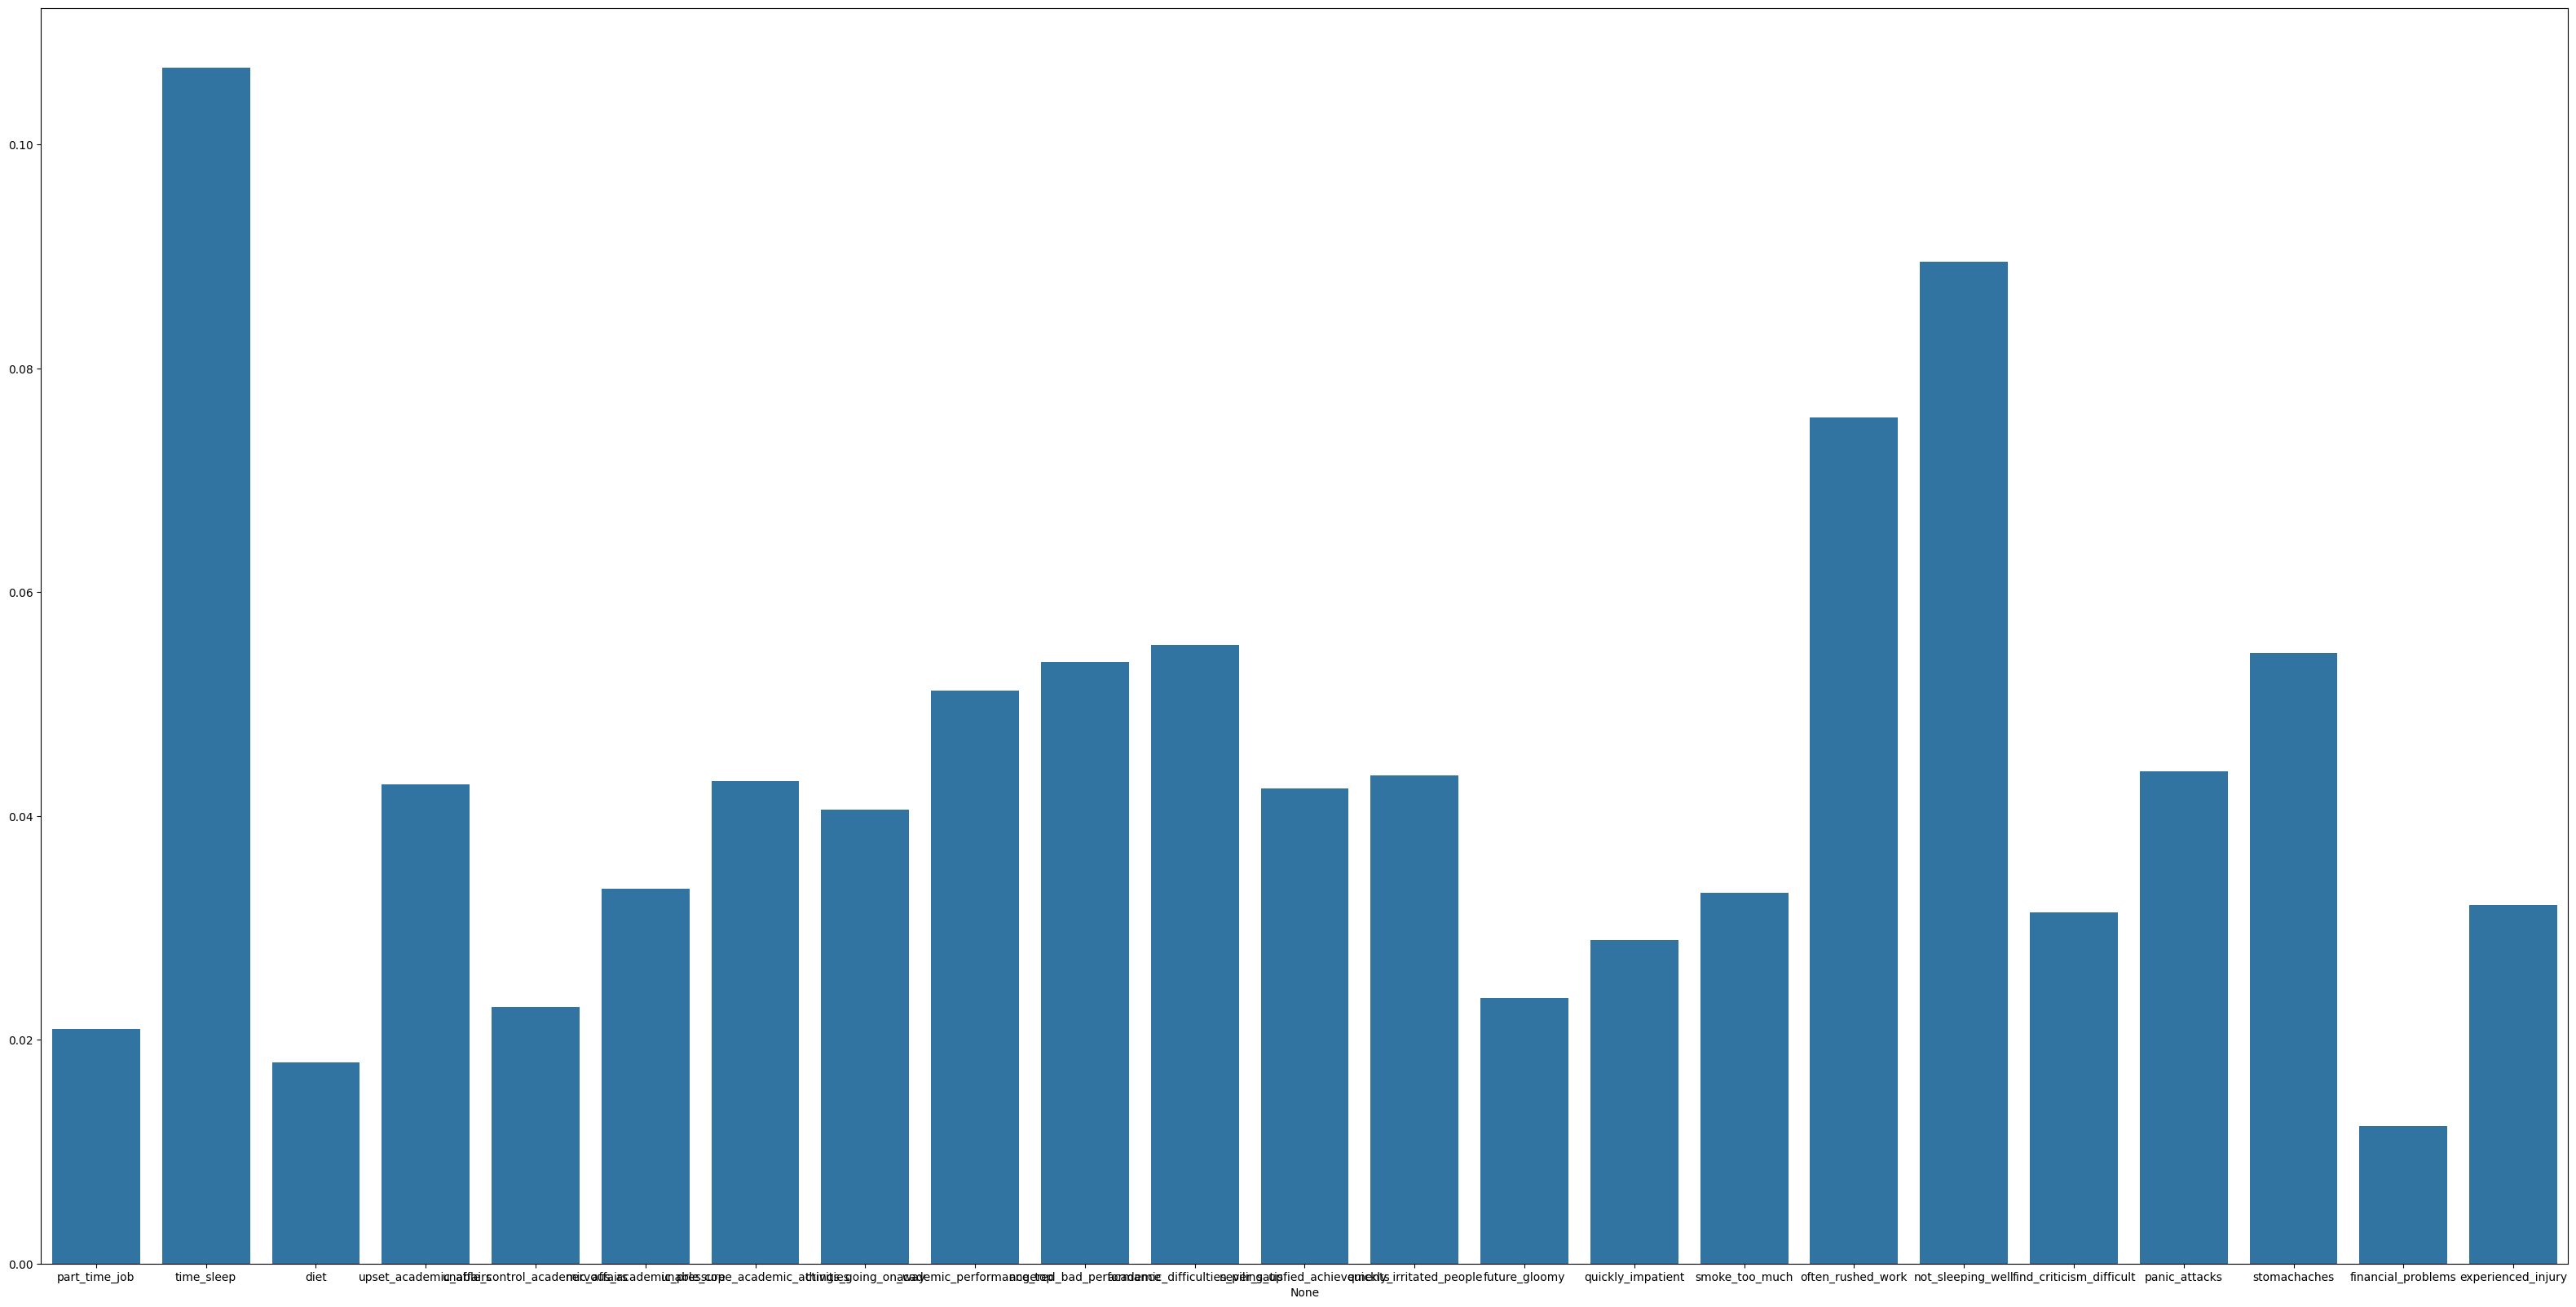

In [585]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=rf.feature_importances_, x=X_fontys_stress.columns)
plt.show()

#### Decision tree

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Features and target
X = fontys_stress[['time_studying', 'career_pursue', 'part_time_job', 'time_sleep', 'diet',
                   'time_physical_activities', 'upset_academic_affairs', 'unable_control_academic_affairs',
                   'nervous_academic_pressure', 'unable_cope_academic_activities',
                   'confident_handle_academic_problems', 'things_going_on_way',
                   'control_irritations_academic_affairs', 'academic_performance_top',
                   'angered_bad_performance', 'academic_difficulties_piling_up',
                   'never_satisfied_achievements', 'quickly_irritated_people', 'future_gloomy',
                   'quickly_impatient', 'smoke_too_much', 'hard_think_clearly', 'often_rushed_work',
                   'not_sleeping_well', 'sensitive_noise', 'find_criticism_difficult', 'panic_attacks',
                   'stomachaches', 'moved_house', 'changes_lifestyle', 'financial_problems',
                   'sexual_problems', 'fellow_people_sick', 'experienced_injury',
                   'separated_family', 'experienced_death']]
y = fontys_stress['stress_level']

# Classifier
dtcs = DecisionTreeClassifier(random_state=42)

# Stratified K-Fold setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model
scores = cross_val_score(dtcs, X, y, cv=cv)

print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.5        0.625      0.42857143 0.71428571 0.14285714]
Mean accuracy: 0.4821428571428571


In [587]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
score = dtc.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.375


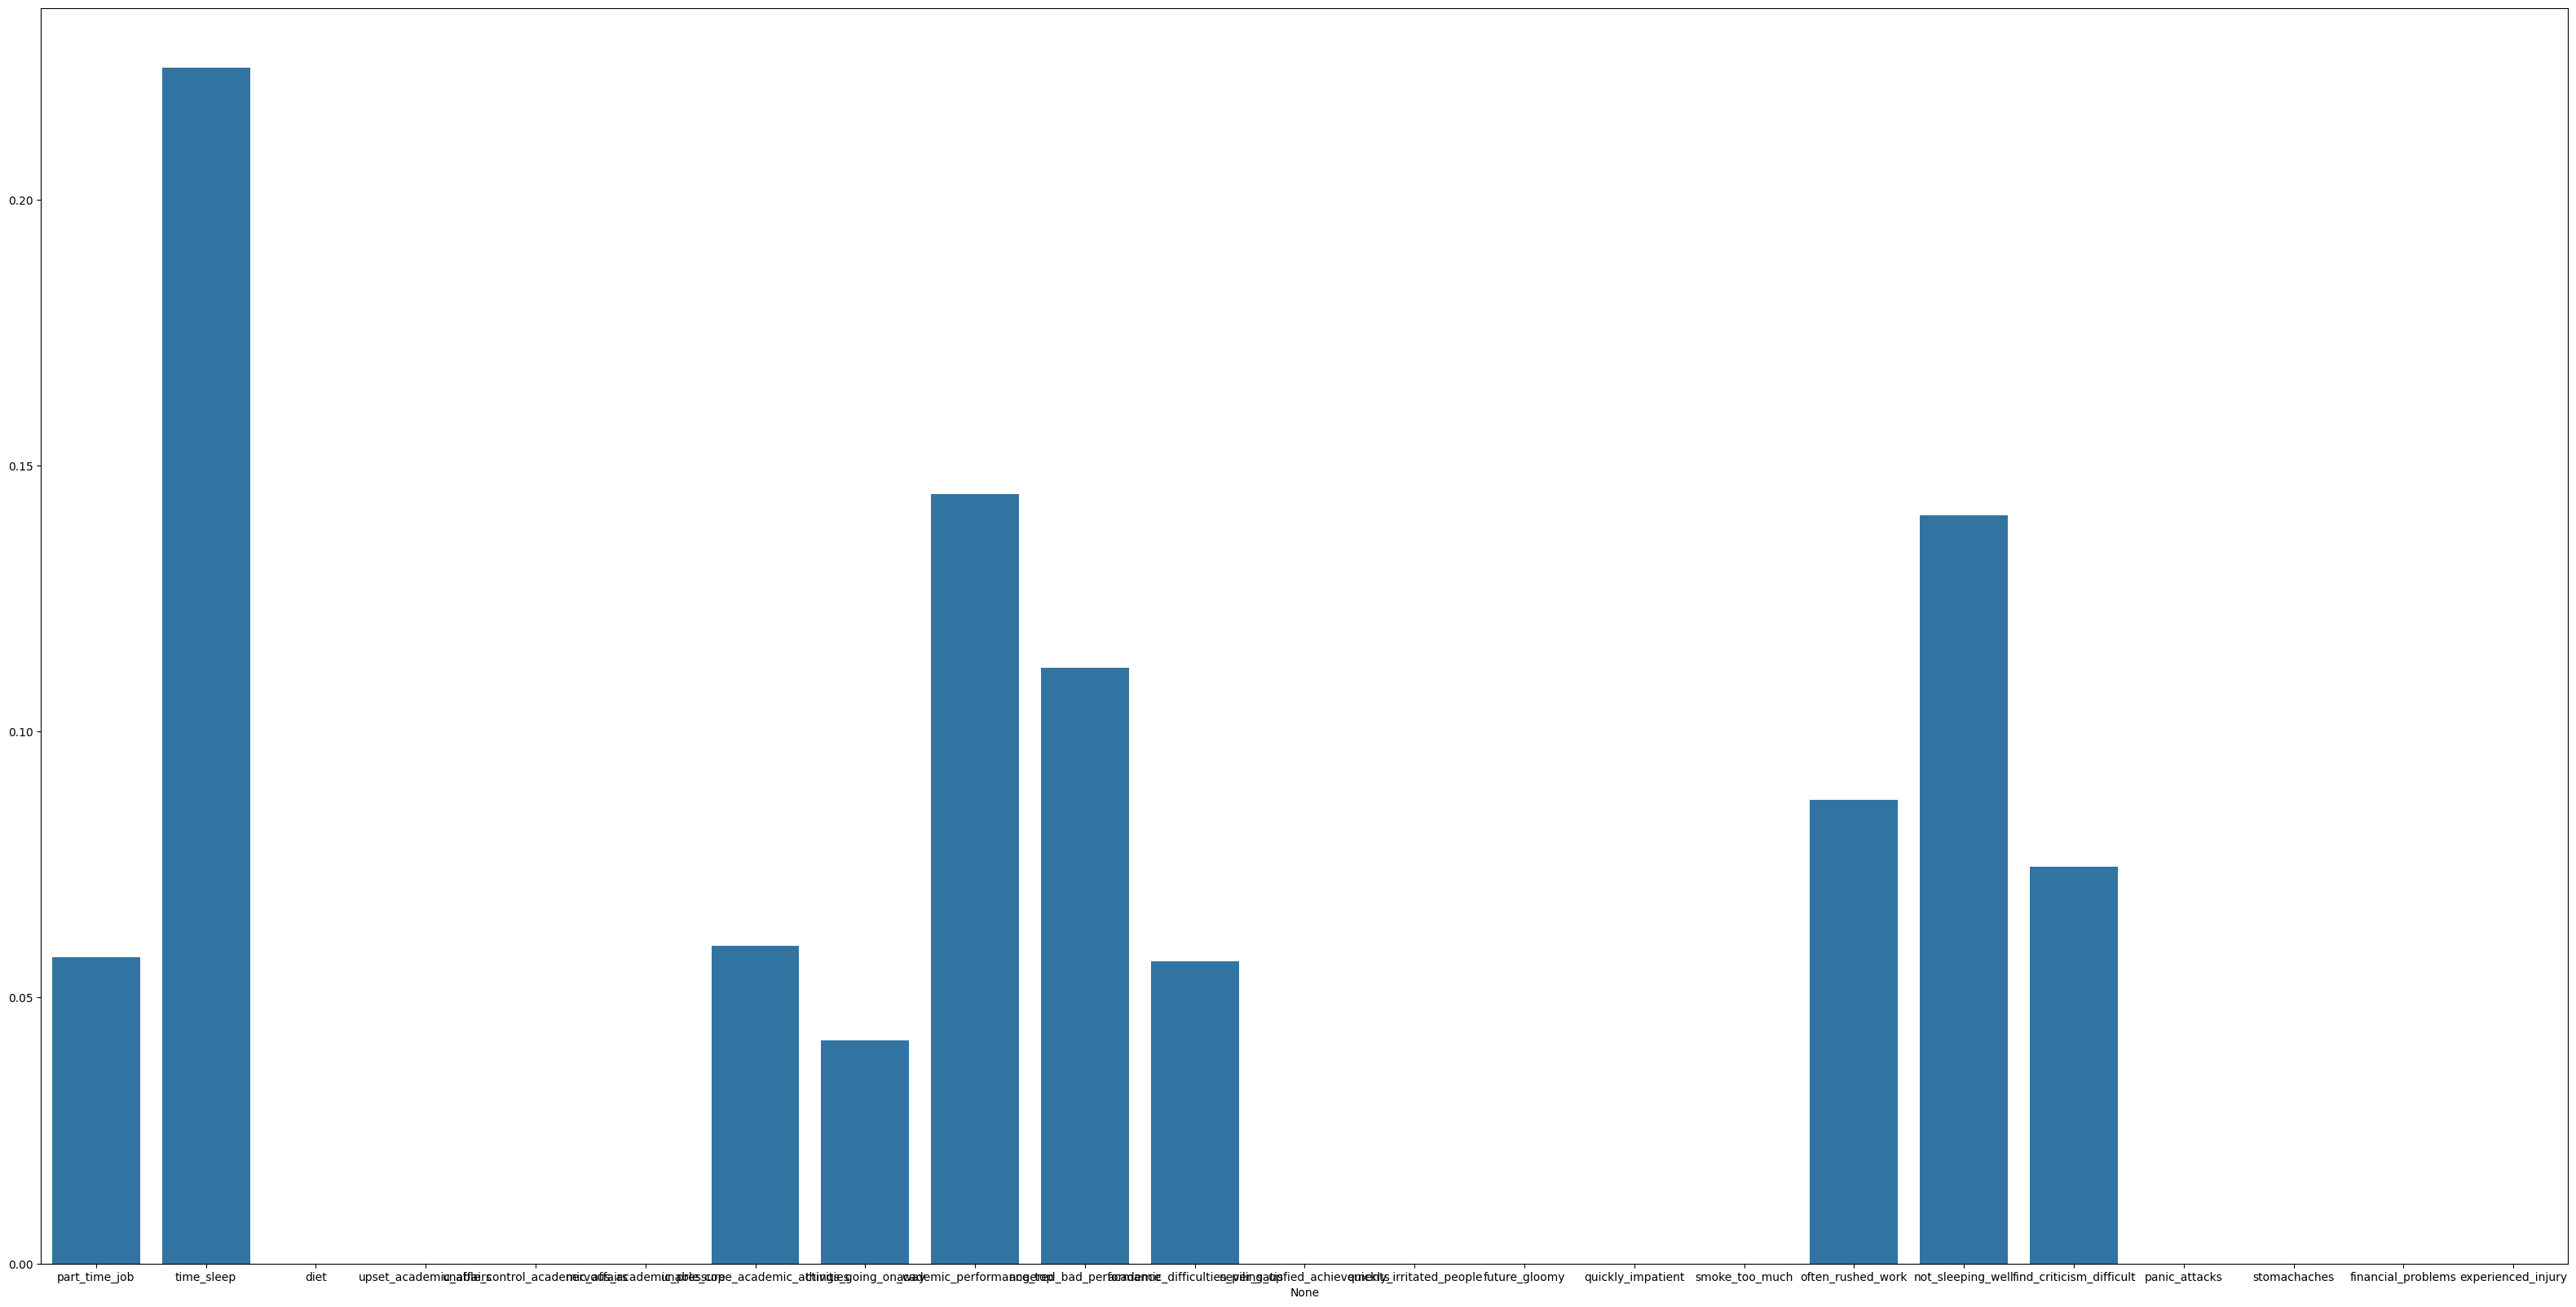

In [588]:
plt.figure(figsize=(40, 20))
plot = sns.barplot(y=dtc.feature_importances_, x=X_fontys_stress.columns)
plt.show()

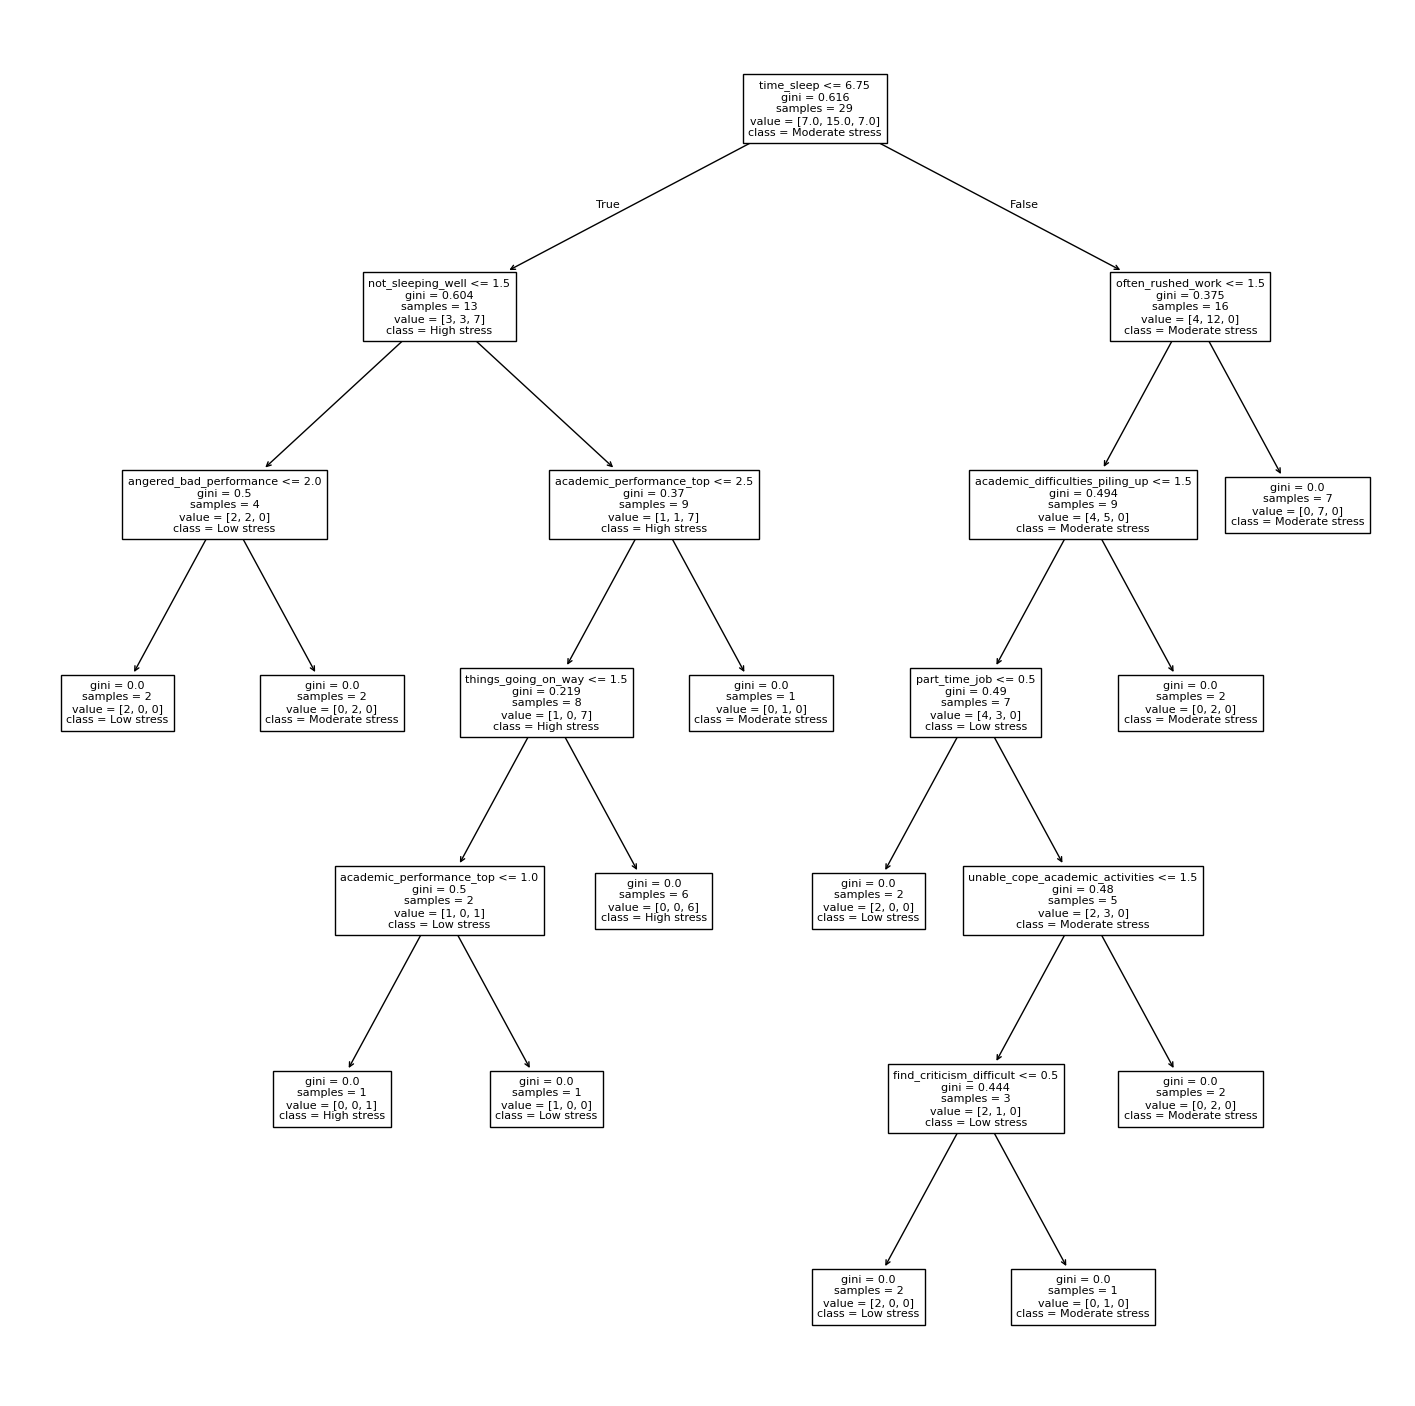

In [589]:
target_names = ["Low stress", "Moderate stress", "High stress"]
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
from sklearn.tree import plot_tree
plot_tree(dtc, fontsize=8, feature_names=X_fontys_stress.columns, class_names=target_names)
plt.show()

In [590]:
predictions = dtc.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.60      0.55         5
           2       0.00      0.00      0.00         3

    accuracy                           0.38         8
   macro avg       0.17      0.20      0.18         8
weighted avg       0.31      0.38      0.34         8



c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ivanb\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita